<a href="https://colab.research.google.com/github/Zardian18/PixelCNN_fashionMNIST/blob/master/PixelCNN_fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-18 02:53:56--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0.001s  

2024-01-18 02:53:56 (22.8 MB/s) - ‘helper.py’ saved [17171/17171]



In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
from helper import display, sample_batch

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [5]:
def preprocess(imgs_int):
  imgs_int = np.expand_dims(imgs_int, -1)
  imgs_int = tf.image.resize(imgs_int, (16,16)).numpy()
  imgs_int = (imgs_int/(256/ 4)).astype(int)
  imgs = imgs_int.astype("float32")
  imgs = imgs/ 4 # 4 = pixel level, higher== clear image
  return imgs, imgs_int

In [6]:
input_data, output_data = preprocess(x_train)

In [7]:
input_data.shape, output_data.shape

((60000, 16, 16, 1), (60000, 16, 16, 1))

In [8]:
input_data[0][3]

array([[0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.5 ],
       [0.5 ],
       [0.25],
       [0.25],
       [0.  ],
       [0.  ],
       [0.25],
       [0.  ]], dtype=float32)

In [9]:
output_data[0][3]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [10]:
np.max(input_data)

0.75

In [11]:
np.max(output_data)

3

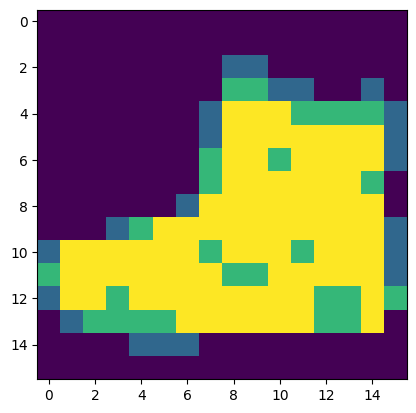

In [12]:
plt.imshow(input_data[0])

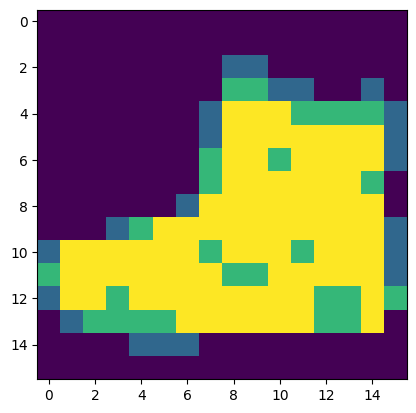

In [13]:
plt.imshow(output_data[0])

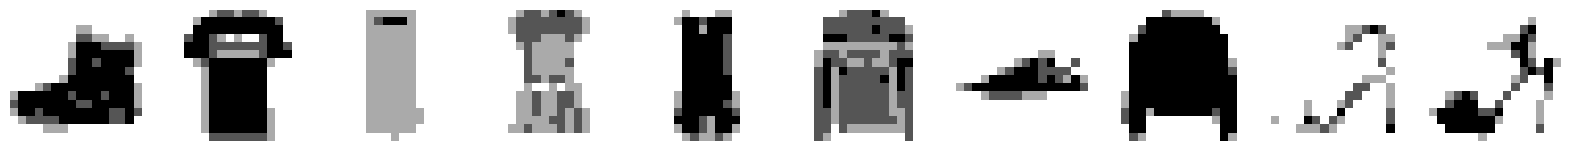

In [14]:
display(input_data) # our preprocessed data

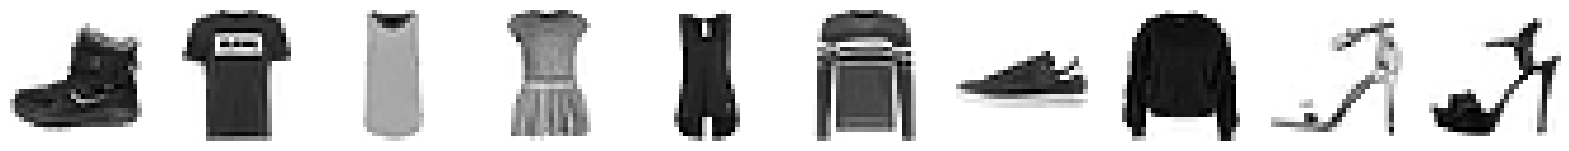

In [15]:
display(x_train) # original data

In [16]:
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        self.conv.build(input_shape)
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [17]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [18]:
# # for rgb

# class MaskedConv2D(layers.Layer):
#     def __init__(self, mask_type, **kwargs):
#         super(MaskedConv2D, self).__init__()
#         self.mask_type = mask_type
#         self.conv = layers.Conv2D(**kwargs)

#     def build(self, input_shape):
#         self.conv.build(input_shape)
#         kernel_shape = self.conv.kernel.get_shape().as_list()
#         num_channels = kernel_shape[-1]

#         self.mask = np.zeros(shape=kernel_shape)

#         for i in range(num_channels):
#             self.mask[: kernel_shape[0] // 2, :, i, :] = 1.0
#             self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, i, :] = 1.0
#             if self.mask_type == "B":
#                 self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, i, :] = 1.0

#     def call(self, inputs):
#         self.conv.kernel.assign(self.conv.kernel * self.mask)
#         return self.conv(inputs)

#     def get_config(self):
#         cfg = super().get_config()
#         return cfg


# class ResidualBlock(layers.Layer):
#     def __init__(self, filters, **kwargs):
#         super(ResidualBlock, self).__init__(**kwargs)
#         self.conv1 = layers.Conv2D(filters=filters // 2, kernel_size=1, activation="relu")
#         self.pixel_conv = MaskedConv2D(
#             mask_type="B",
#             filters=filters // 2,
#             kernel_size=3,
#             activation="relu",
#             padding="same",
#         )
#         self.conv2 = layers.Conv2D(filters=filters, kernel_size=1, activation="relu")

#     def call(self, inputs):
#         if inputs.shape[-1] != self.conv1.filters:
#             raise ValueError("Input channels do not match the expected value.")

#         x = self.conv1(inputs)
#         x = self.pixel_conv(x)

#         if x.shape[-1] != self.conv2.filters:
#             raise ValueError("Intermediate channels do not match the expected value.")

#         x = self.conv2(x)

#         if inputs.shape[-1] != x.shape[-1]:
#             raise ValueError("Input and output channels do not match.")

#         return layers.add([inputs, x])

#     def get_config(self):
#         cfg = super().get_config()
#         return cfg


In [29]:
inputs = layers.Input(shape=(16,16,1))
x = MaskedConv2D(mask_type="A",
                 filters=128,
                 kernel_size=7,
                 activation="relu",
                 padding ="same")(inputs)

for _ in range(5):
  x = ResidualBlock(filters=128)(x)

for _ in range(2):
  x = MaskedConv2D(mask_type ="B",
                   filters=128,
                   kernel_size=1,
                   strides=1,
                   activation="relu",
                   padding="valid")(x)

outputs = layers.Conv2D(filters=4, kernel_size =1, strides=1, activation="softmax", padding ="valid")(x)

pixelcnn = models.Model(inputs, outputs)
pixelcnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d_16 (MaskedCo  (None, 16, 16, 128)       6400      
 nv2D)                                                           
                                                                 
 residual_block_10 (Residua  (None, 16, 16, 128)       53504     
 lBlock)                                                         
                                                                 
 residual_block_11 (Residua  (None, 16, 16, 128)       53504     
 lBlock)                                                         
                                                                 
 residual_block_12 (Residua  (None, 16, 16, 128)       53504     
 lBlock)                                                   

In [20]:
adam = optimizers.Adam(learning_rate=0.0005)
pixelcnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [24]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixelcnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= 4

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

In [22]:
! mkdir output/

Epoch 1/150
  5/469 [..............................] - ETA: 17s - loss: 0.4159

467/469 [============================>.] - ETA: 0s - loss: 0.3964
Saved to ./output/generated_img_000.png


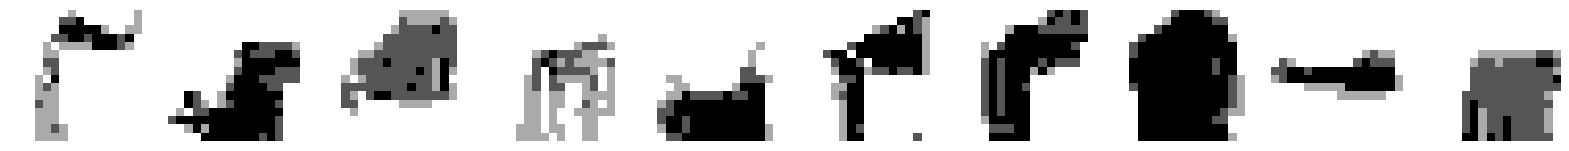

469/469 [==============================] - 29s 62ms/step - loss: 0.3964
Epoch 2/150
469/469 [==============================] - ETA: 0s - loss: 0.3852
Saved to ./output/generated_img_001.png


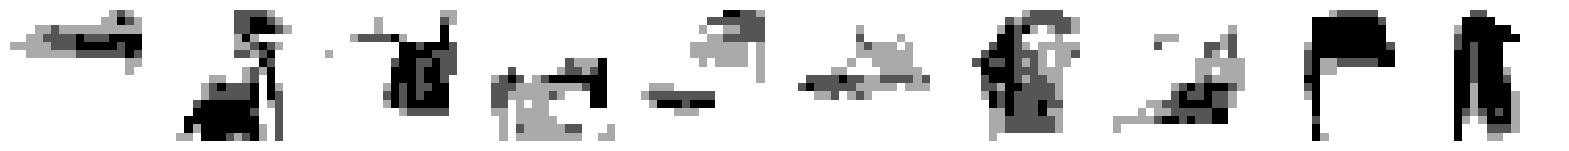

469/469 [==============================] - 30s 65ms/step - loss: 0.3852
Epoch 3/150
467/469 [============================>.] - ETA: 0s - loss: 0.3788
Saved to ./output/generated_img_002.png


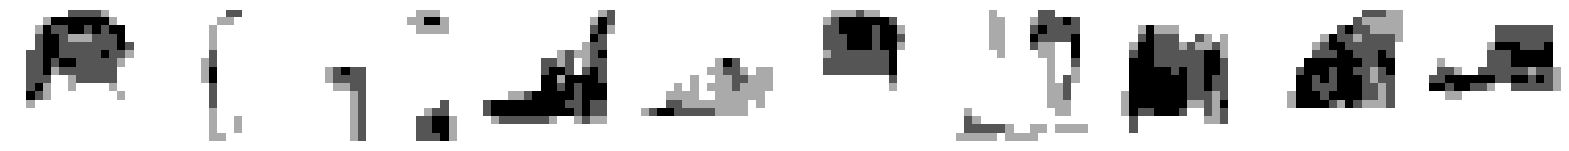

469/469 [==============================] - 30s 64ms/step - loss: 0.3788
Epoch 4/150
469/469 [==============================] - ETA: 0s - loss: 0.3745
Saved to ./output/generated_img_003.png


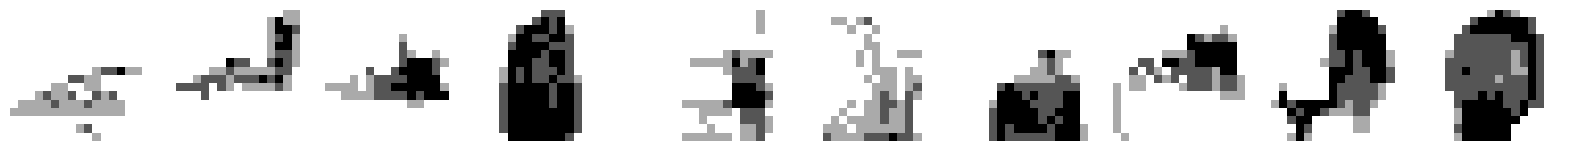

469/469 [==============================] - 30s 63ms/step - loss: 0.3745
Epoch 5/150
467/469 [============================>.] - ETA: 0s - loss: 0.3712
Saved to ./output/generated_img_004.png


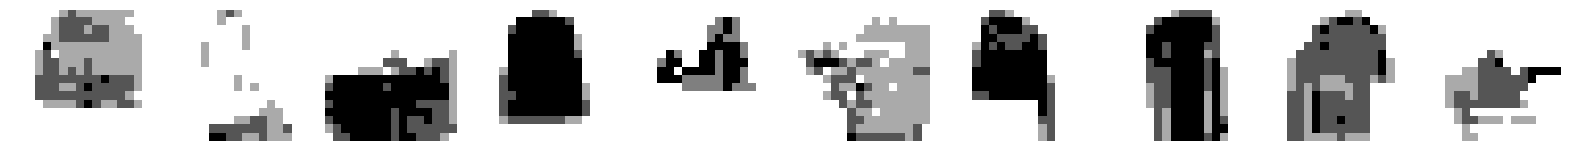

469/469 [==============================] - 29s 62ms/step - loss: 0.3712
Epoch 6/150
469/469 [==============================] - ETA: 0s - loss: 0.3681
Saved to ./output/generated_img_005.png


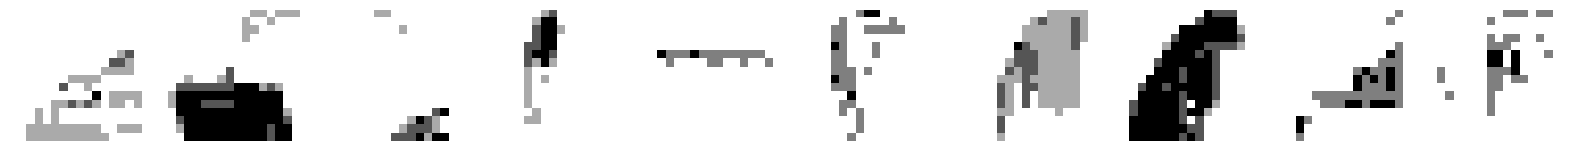

469/469 [==============================] - 30s 64ms/step - loss: 0.3681
Epoch 7/150
469/469 [==============================] - ETA: 0s - loss: 0.3659
Saved to ./output/generated_img_006.png


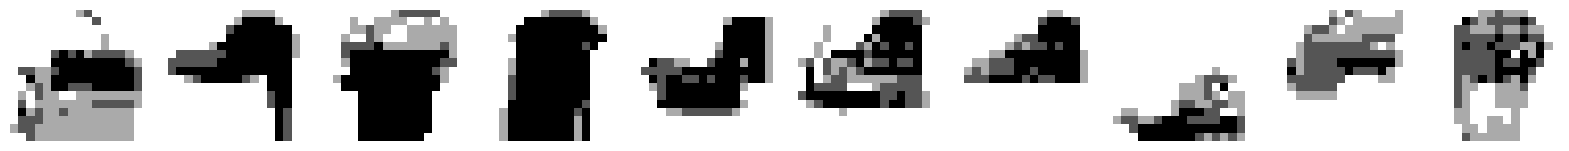

469/469 [==============================] - 31s 66ms/step - loss: 0.3659
Epoch 8/150
469/469 [==============================] - ETA: 0s - loss: 0.3636
Saved to ./output/generated_img_007.png


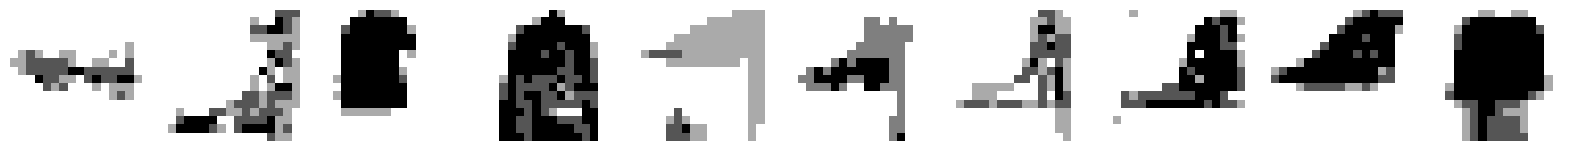

469/469 [==============================] - 30s 63ms/step - loss: 0.3636
Epoch 9/150
469/469 [==============================] - ETA: 0s - loss: 0.3619
Saved to ./output/generated_img_008.png


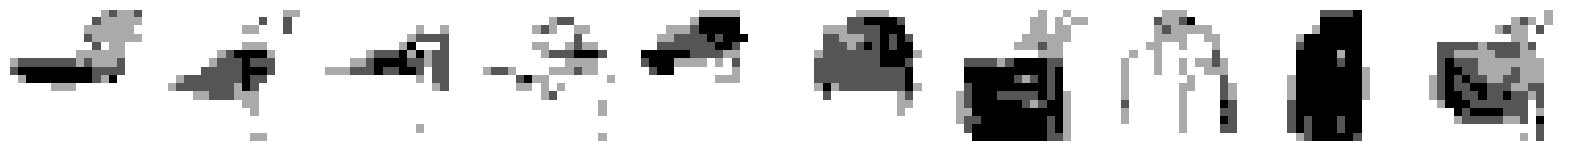

469/469 [==============================] - 31s 66ms/step - loss: 0.3619
Epoch 10/150
469/469 [==============================] - ETA: 0s - loss: 0.3599
Saved to ./output/generated_img_009.png


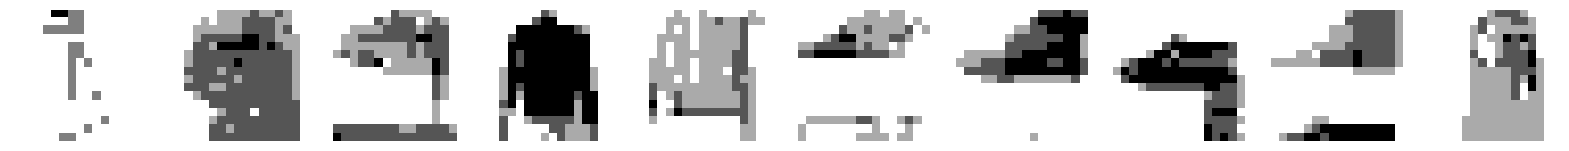

469/469 [==============================] - 30s 64ms/step - loss: 0.3599
Epoch 11/150
469/469 [==============================] - ETA: 0s - loss: 0.3581
Saved to ./output/generated_img_010.png


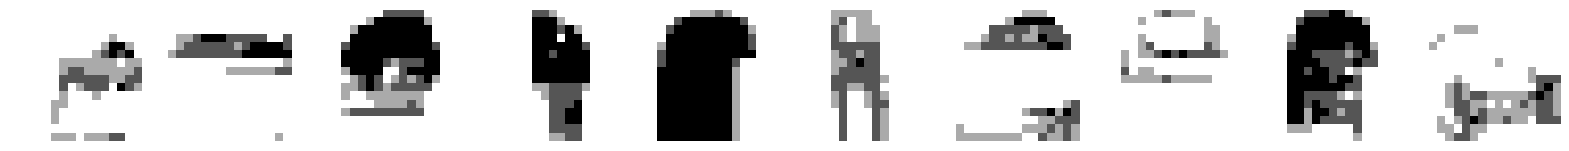

469/469 [==============================] - 30s 63ms/step - loss: 0.3581
Epoch 12/150
469/469 [==============================] - ETA: 0s - loss: 0.3561
Saved to ./output/generated_img_011.png


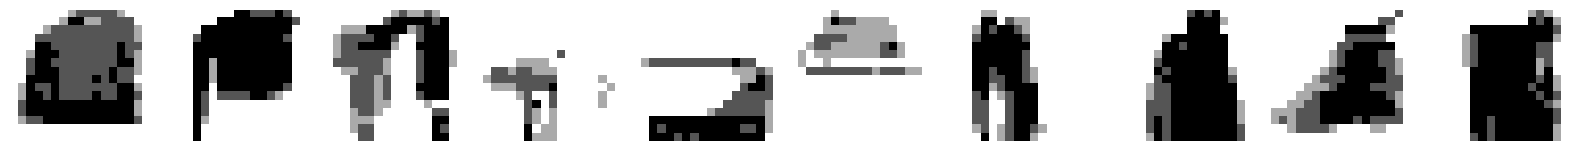

469/469 [==============================] - 31s 66ms/step - loss: 0.3561
Epoch 13/150
469/469 [==============================] - ETA: 0s - loss: 0.3546
Saved to ./output/generated_img_012.png


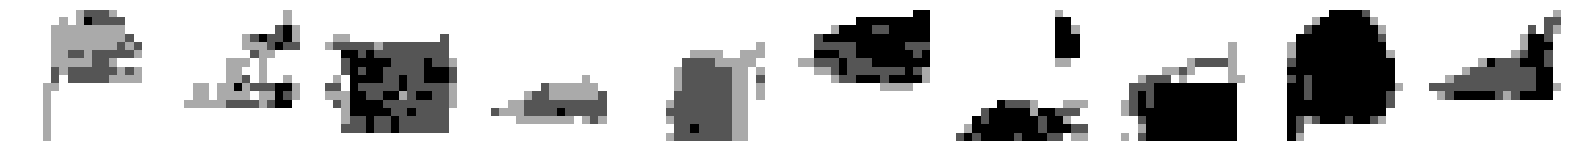

469/469 [==============================] - 29s 62ms/step - loss: 0.3546
Epoch 14/150
469/469 [==============================] - ETA: 0s - loss: 0.3531
Saved to ./output/generated_img_013.png


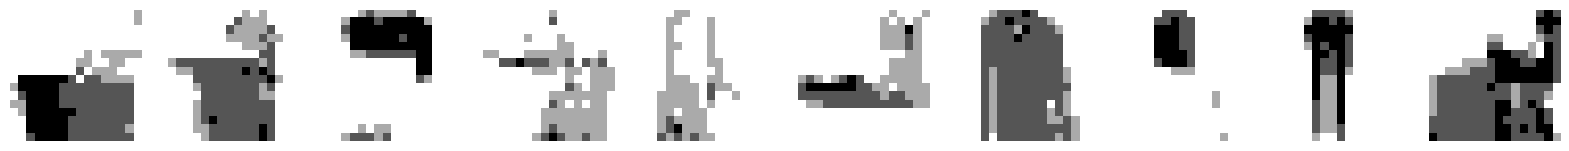

469/469 [==============================] - 30s 64ms/step - loss: 0.3531
Epoch 15/150
467/469 [============================>.] - ETA: 0s - loss: 0.3521
Saved to ./output/generated_img_014.png


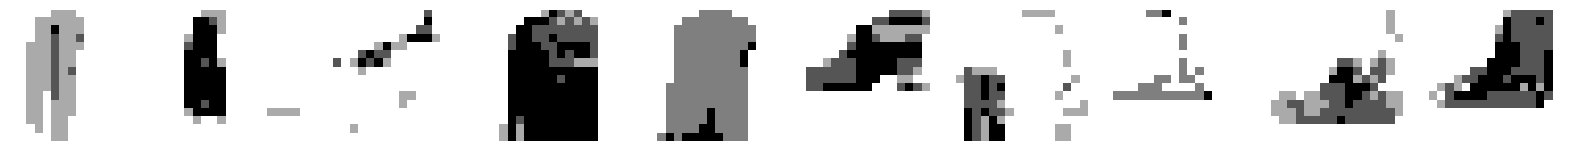

469/469 [==============================] - 30s 65ms/step - loss: 0.3521
Epoch 16/150
467/469 [============================>.] - ETA: 0s - loss: 0.3506
Saved to ./output/generated_img_015.png


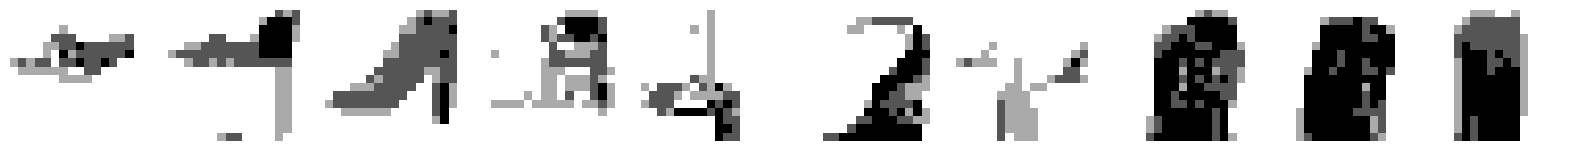

469/469 [==============================] - 29s 62ms/step - loss: 0.3506
Epoch 17/150
467/469 [============================>.] - ETA: 0s - loss: 0.3497
Saved to ./output/generated_img_016.png


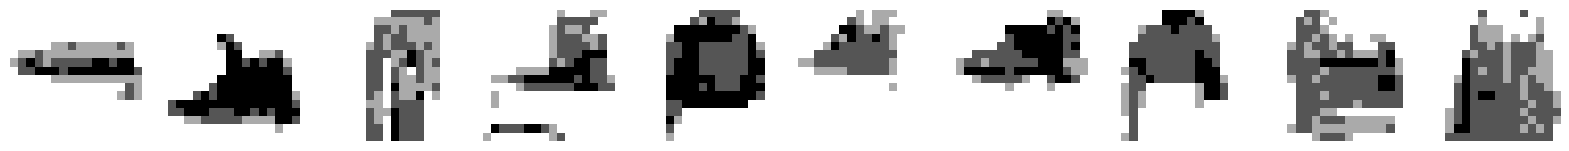

469/469 [==============================] - 29s 62ms/step - loss: 0.3497
Epoch 18/150
469/469 [==============================] - ETA: 0s - loss: 0.3487
Saved to ./output/generated_img_017.png


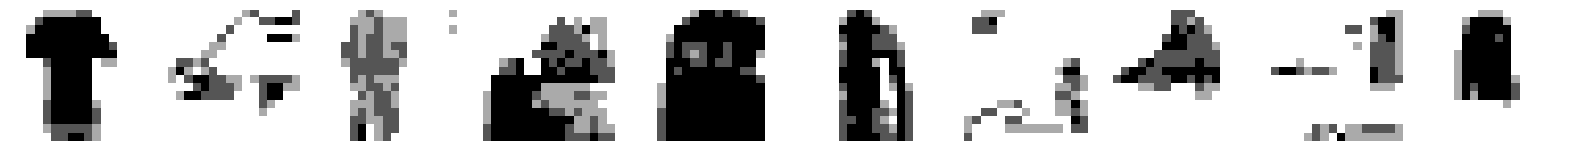

469/469 [==============================] - 31s 65ms/step - loss: 0.3487
Epoch 19/150
469/469 [==============================] - ETA: 0s - loss: 0.3479
Saved to ./output/generated_img_018.png


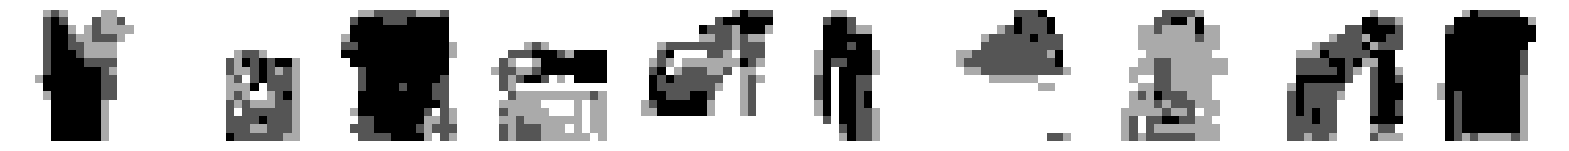

469/469 [==============================] - 29s 62ms/step - loss: 0.3479
Epoch 20/150
469/469 [==============================] - ETA: 0s - loss: 0.3472
Saved to ./output/generated_img_019.png


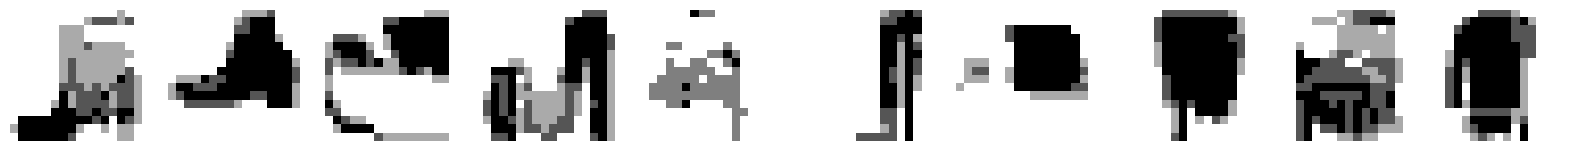

469/469 [==============================] - 30s 63ms/step - loss: 0.3472
Epoch 21/150
467/469 [============================>.] - ETA: 0s - loss: 0.3460
Saved to ./output/generated_img_020.png


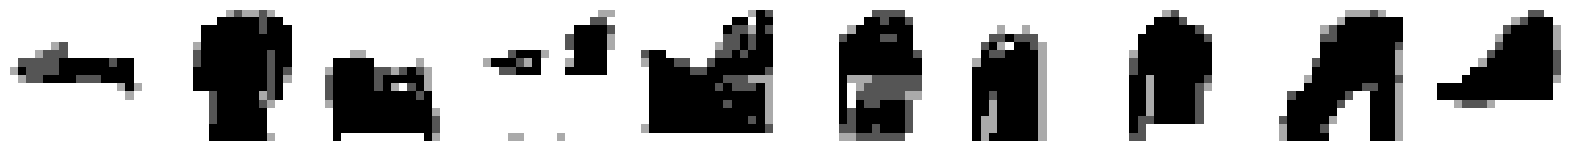

469/469 [==============================] - 31s 66ms/step - loss: 0.3460
Epoch 22/150
469/469 [==============================] - ETA: 0s - loss: 0.3454
Saved to ./output/generated_img_021.png


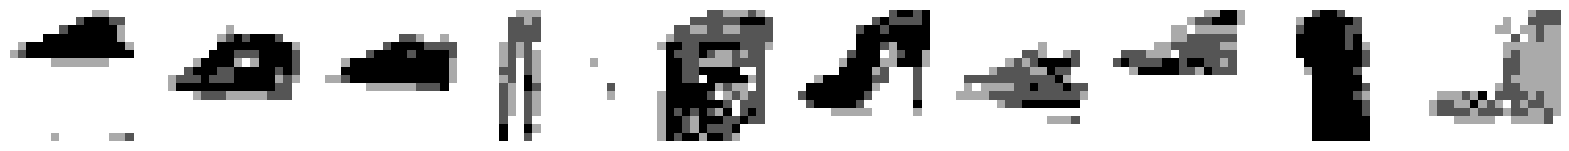

469/469 [==============================] - 30s 64ms/step - loss: 0.3454
Epoch 23/150
467/469 [============================>.] - ETA: 0s - loss: 0.3448
Saved to ./output/generated_img_022.png


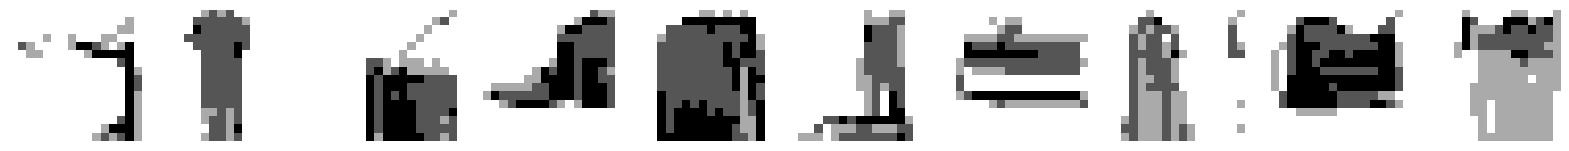

469/469 [==============================] - 30s 64ms/step - loss: 0.3447
Epoch 24/150
469/469 [==============================] - ETA: 0s - loss: 0.3441
Saved to ./output/generated_img_023.png


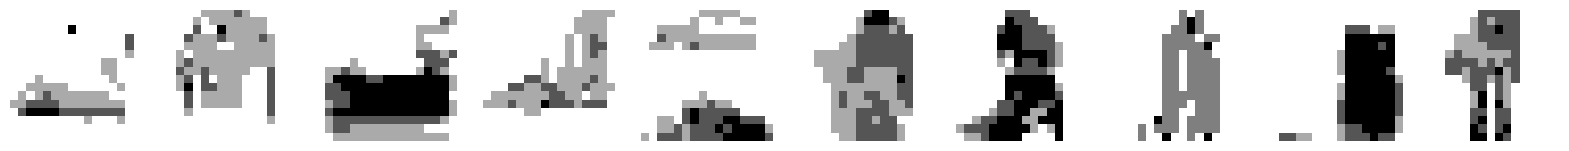

469/469 [==============================] - 29s 63ms/step - loss: 0.3441
Epoch 25/150
469/469 [==============================] - ETA: 0s - loss: 0.3433
Saved to ./output/generated_img_024.png


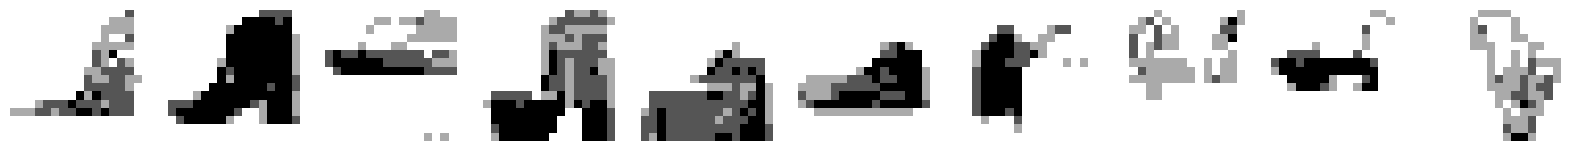

469/469 [==============================] - 30s 64ms/step - loss: 0.3433
Epoch 26/150
469/469 [==============================] - ETA: 0s - loss: 0.3428
Saved to ./output/generated_img_025.png


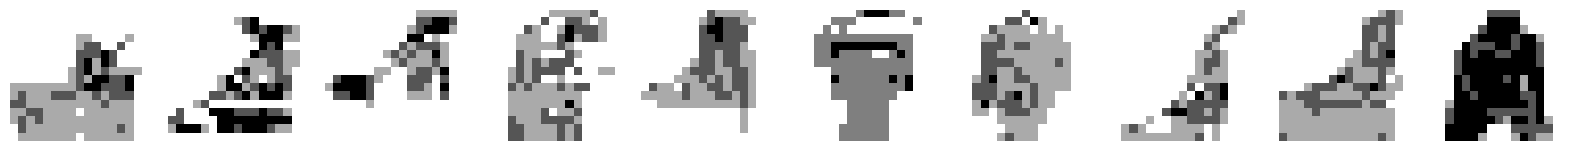

469/469 [==============================] - 30s 64ms/step - loss: 0.3428
Epoch 27/150
469/469 [==============================] - ETA: 0s - loss: 0.3422
Saved to ./output/generated_img_026.png


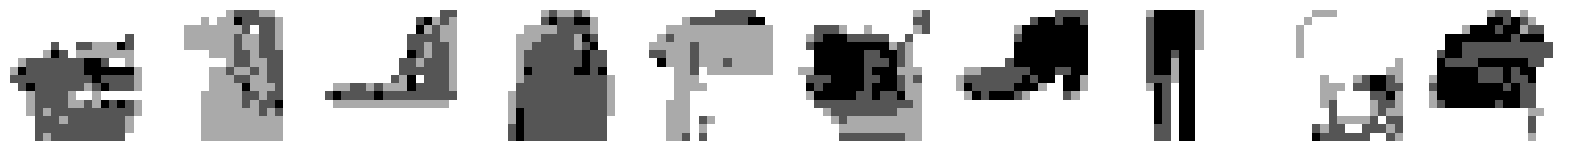

469/469 [==============================] - 29s 63ms/step - loss: 0.3422
Epoch 28/150
469/469 [==============================] - ETA: 0s - loss: 0.3416
Saved to ./output/generated_img_027.png


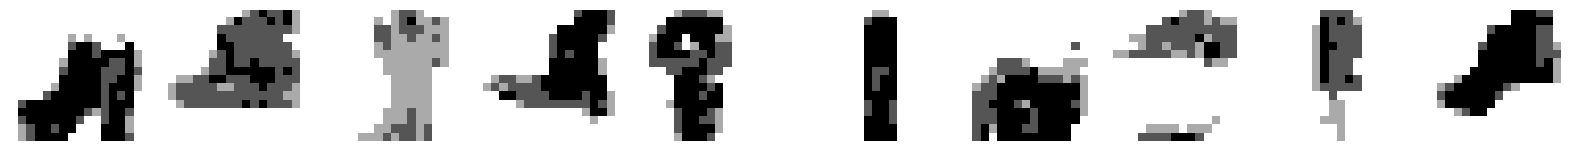

469/469 [==============================] - 33s 70ms/step - loss: 0.3416
Epoch 29/150
467/469 [============================>.] - ETA: 0s - loss: 0.3412
Saved to ./output/generated_img_028.png


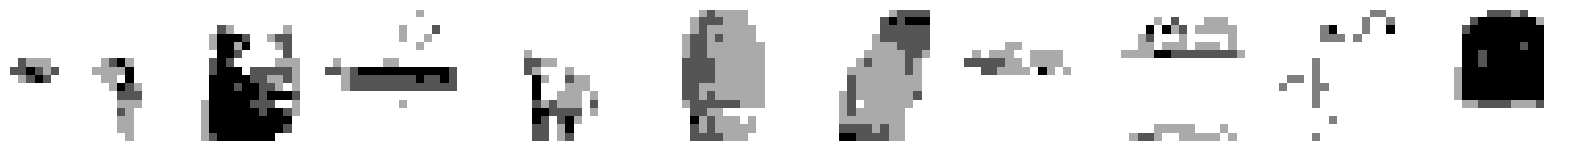

469/469 [==============================] - 29s 62ms/step - loss: 0.3412
Epoch 30/150
467/469 [============================>.] - ETA: 0s - loss: 0.3406
Saved to ./output/generated_img_029.png


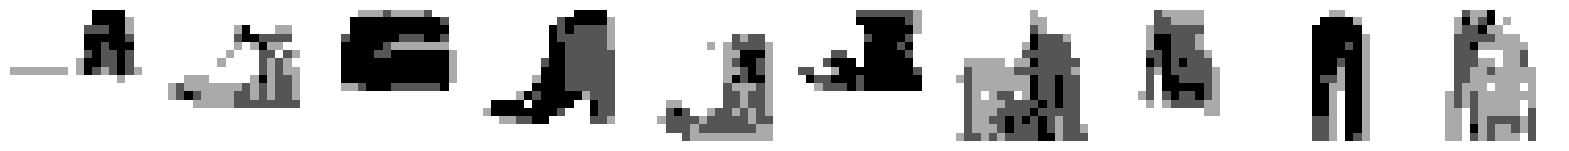

469/469 [==============================] - 30s 63ms/step - loss: 0.3406
Epoch 31/150
469/469 [==============================] - ETA: 0s - loss: 0.3401
Saved to ./output/generated_img_030.png


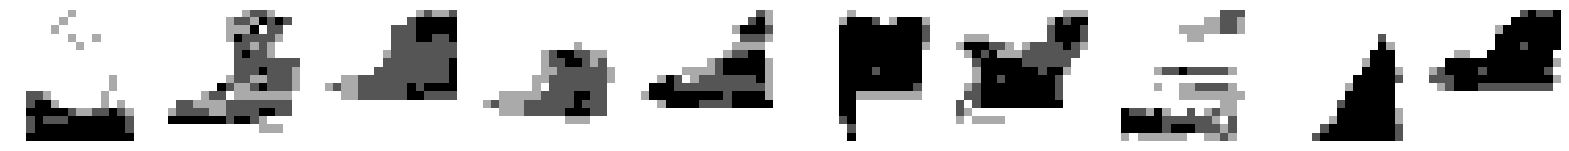

469/469 [==============================] - 30s 64ms/step - loss: 0.3401
Epoch 32/150
467/469 [============================>.] - ETA: 0s - loss: 0.3399
Saved to ./output/generated_img_031.png


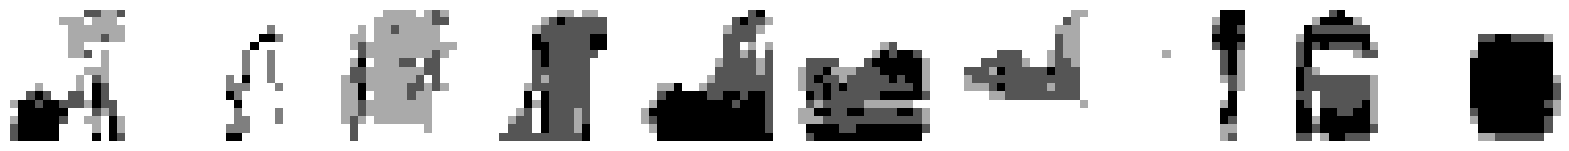

469/469 [==============================] - 29s 62ms/step - loss: 0.3398
Epoch 33/150
467/469 [============================>.] - ETA: 0s - loss: 0.3392
Saved to ./output/generated_img_032.png


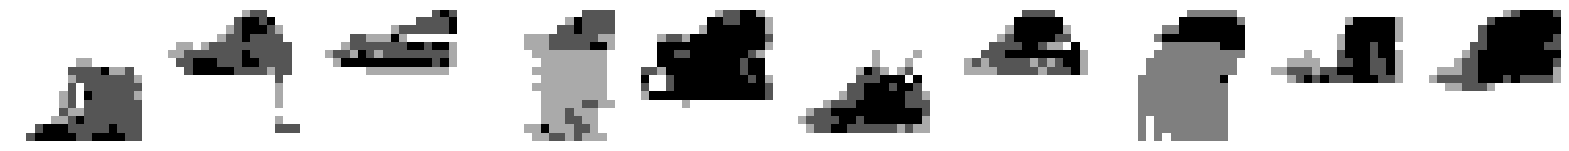

469/469 [==============================] - 30s 64ms/step - loss: 0.3392
Epoch 34/150
469/469 [==============================] - ETA: 0s - loss: 0.3387
Saved to ./output/generated_img_033.png


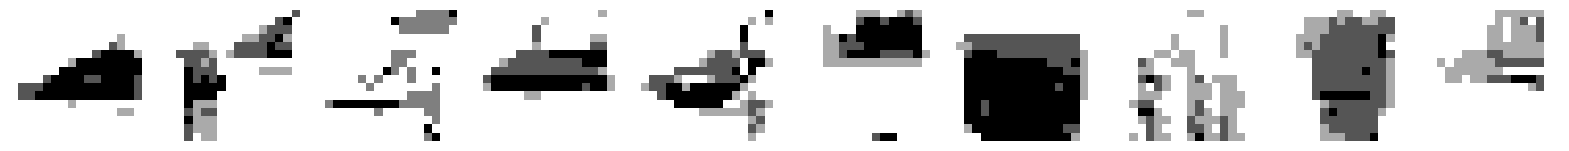

469/469 [==============================] - 30s 64ms/step - loss: 0.3387
Epoch 35/150
467/469 [============================>.] - ETA: 0s - loss: 0.3385
Saved to ./output/generated_img_034.png


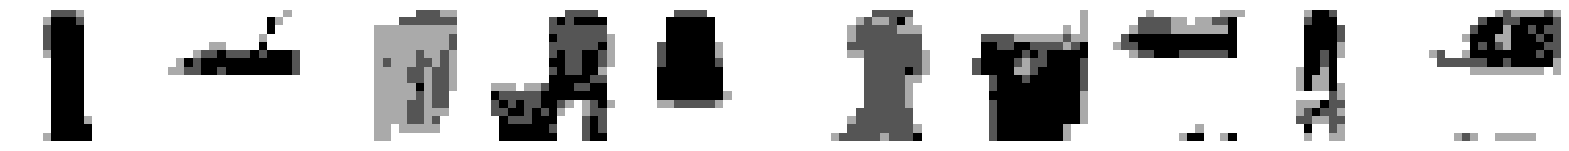

469/469 [==============================] - 31s 66ms/step - loss: 0.3384
Epoch 36/150
469/469 [==============================] - ETA: 0s - loss: 0.3381
Saved to ./output/generated_img_035.png


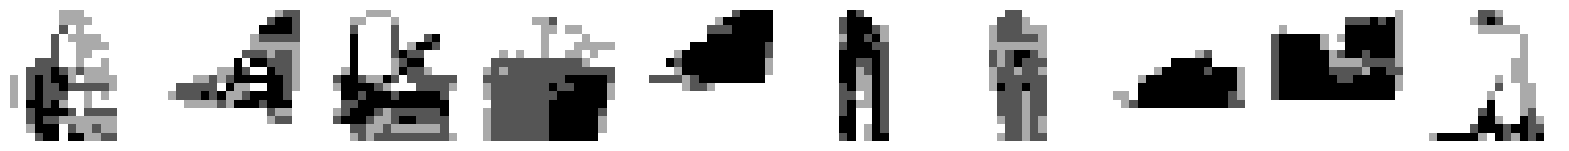

469/469 [==============================] - 32s 68ms/step - loss: 0.3381
Epoch 37/150
467/469 [============================>.] - ETA: 0s - loss: 0.3379
Saved to ./output/generated_img_036.png


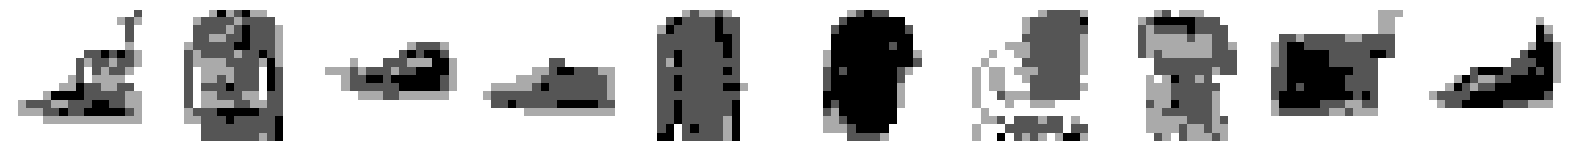

469/469 [==============================] - 31s 65ms/step - loss: 0.3379
Epoch 38/150
469/469 [==============================] - ETA: 0s - loss: 0.3373
Saved to ./output/generated_img_037.png


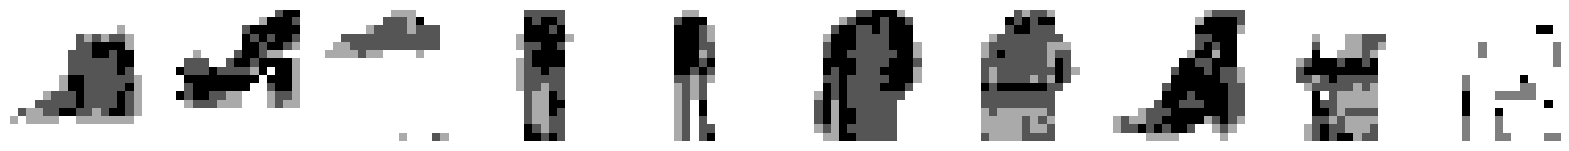

469/469 [==============================] - 31s 66ms/step - loss: 0.3373
Epoch 39/150
467/469 [============================>.] - ETA: 0s - loss: 0.3367
Saved to ./output/generated_img_038.png


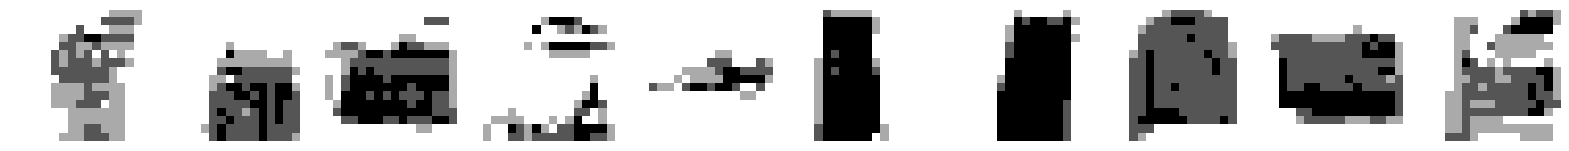

469/469 [==============================] - 30s 64ms/step - loss: 0.3367
Epoch 40/150
469/469 [==============================] - ETA: 0s - loss: 0.3365
Saved to ./output/generated_img_039.png


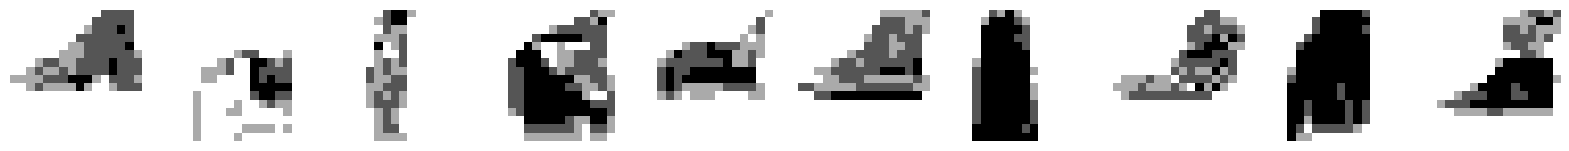

469/469 [==============================] - 29s 63ms/step - loss: 0.3365
Epoch 41/150
467/469 [============================>.] - ETA: 0s - loss: 0.3361
Saved to ./output/generated_img_040.png


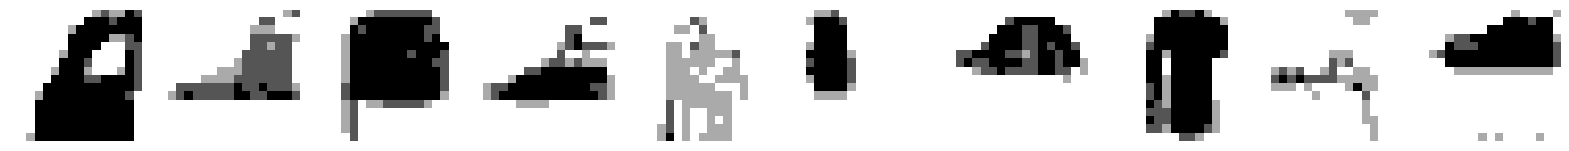

469/469 [==============================] - 32s 69ms/step - loss: 0.3362
Epoch 42/150
469/469 [==============================] - ETA: 0s - loss: 0.3362
Saved to ./output/generated_img_041.png


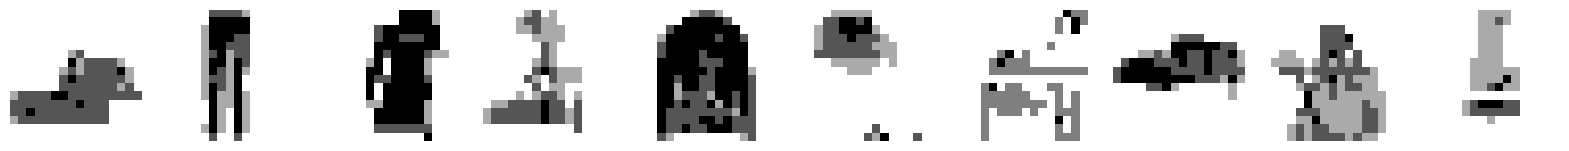

469/469 [==============================] - 30s 64ms/step - loss: 0.3362
Epoch 43/150
469/469 [==============================] - ETA: 0s - loss: 0.3354
Saved to ./output/generated_img_042.png


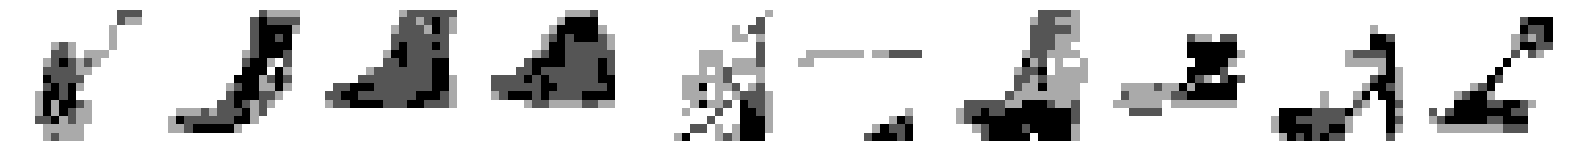

469/469 [==============================] - 30s 63ms/step - loss: 0.3354
Epoch 44/150
467/469 [============================>.] - ETA: 0s - loss: 0.3353
Saved to ./output/generated_img_043.png


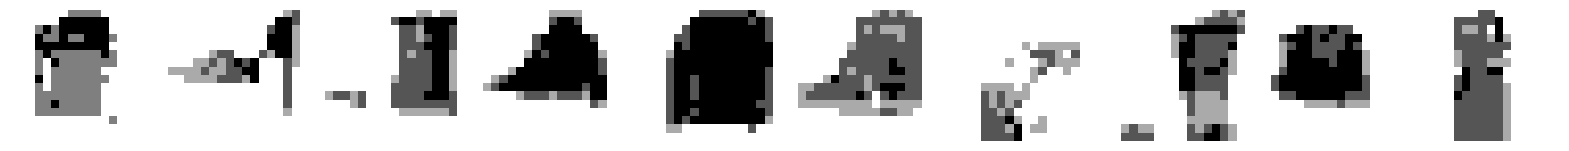

469/469 [==============================] - 32s 67ms/step - loss: 0.3353
Epoch 45/150
467/469 [============================>.] - ETA: 0s - loss: 0.3350
Saved to ./output/generated_img_044.png


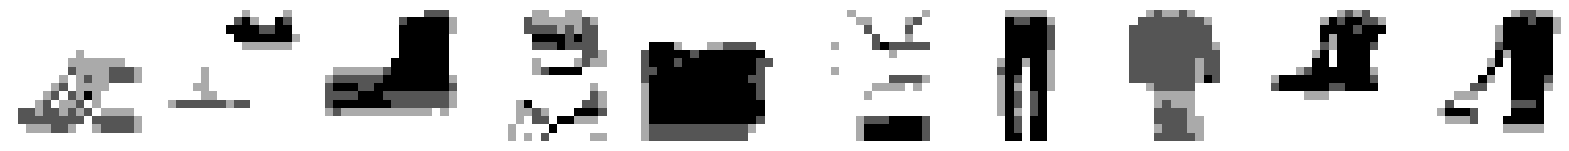

469/469 [==============================] - 29s 63ms/step - loss: 0.3350
Epoch 46/150
469/469 [==============================] - ETA: 0s - loss: 0.3346
Saved to ./output/generated_img_045.png


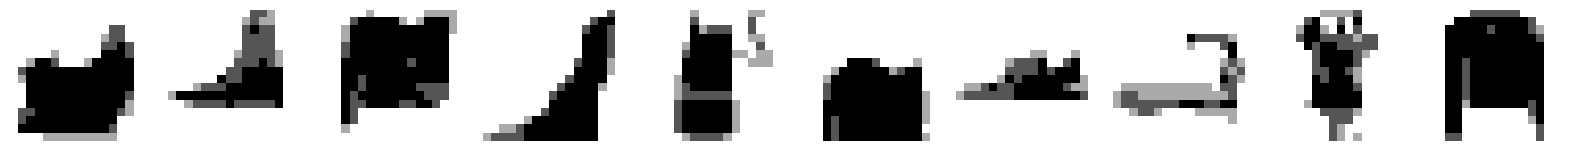

469/469 [==============================] - 30s 64ms/step - loss: 0.3346
Epoch 47/150
469/469 [==============================] - ETA: 0s - loss: 0.3343
Saved to ./output/generated_img_046.png


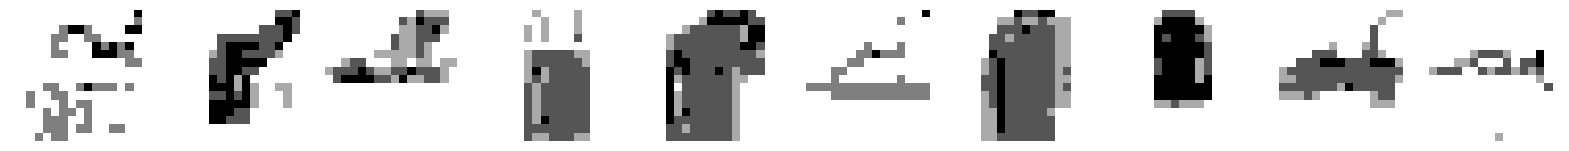

469/469 [==============================] - 31s 66ms/step - loss: 0.3343
Epoch 48/150
469/469 [==============================] - ETA: 0s - loss: 0.3342
Saved to ./output/generated_img_047.png


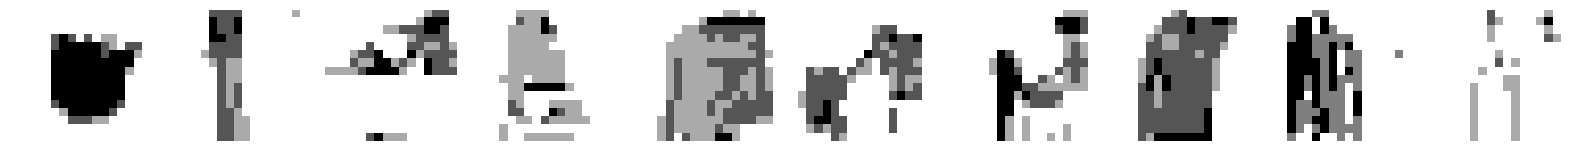

469/469 [==============================] - 30s 63ms/step - loss: 0.3342
Epoch 49/150
469/469 [==============================] - ETA: 0s - loss: 0.3340
Saved to ./output/generated_img_048.png


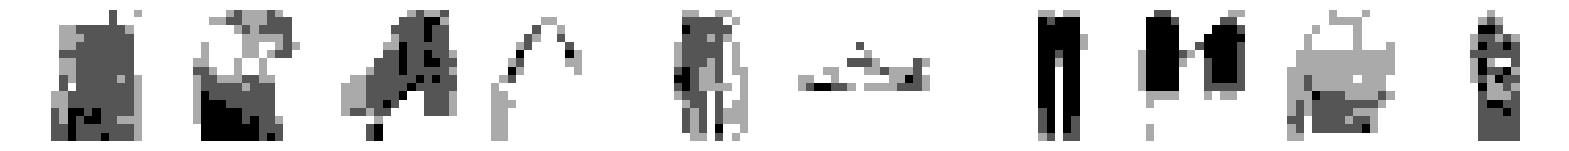

469/469 [==============================] - 32s 68ms/step - loss: 0.3340
Epoch 50/150
467/469 [============================>.] - ETA: 0s - loss: 0.3338
Saved to ./output/generated_img_049.png


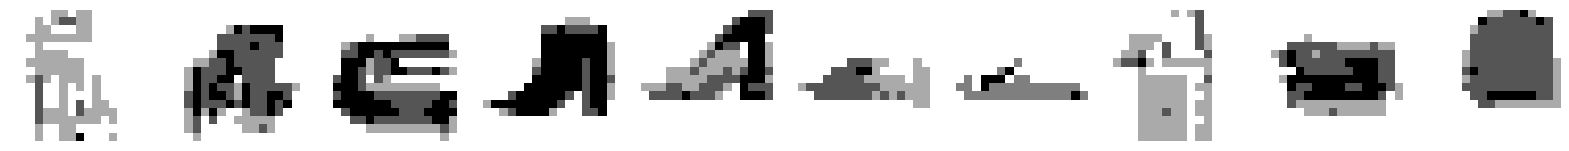

469/469 [==============================] - 30s 63ms/step - loss: 0.3338
Epoch 51/150
467/469 [============================>.] - ETA: 0s - loss: 0.3334
Saved to ./output/generated_img_050.png


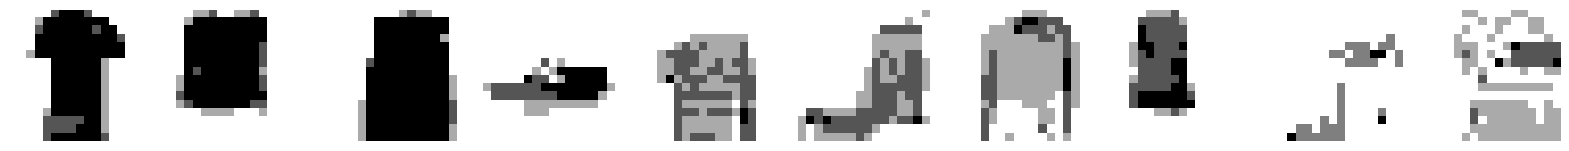

469/469 [==============================] - 29s 62ms/step - loss: 0.3334
Epoch 52/150
467/469 [============================>.] - ETA: 0s - loss: 0.3332
Saved to ./output/generated_img_051.png


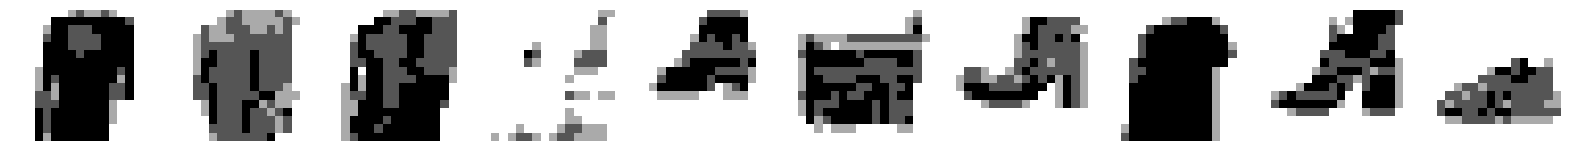

469/469 [==============================] - 31s 67ms/step - loss: 0.3332
Epoch 53/150
467/469 [============================>.] - ETA: 0s - loss: 0.3328
Saved to ./output/generated_img_052.png


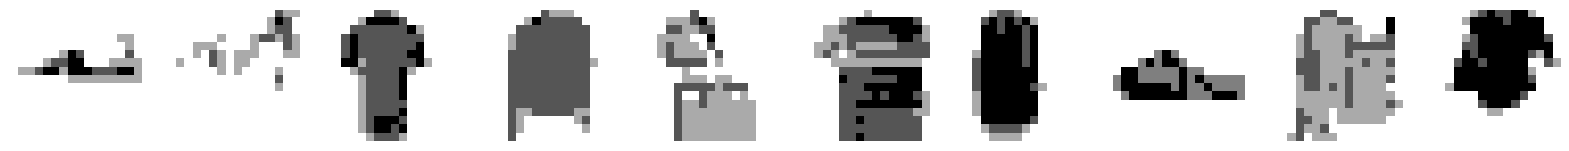

469/469 [==============================] - 30s 63ms/step - loss: 0.3329
Epoch 54/150
469/469 [==============================] - ETA: 0s - loss: 0.3327
Saved to ./output/generated_img_053.png


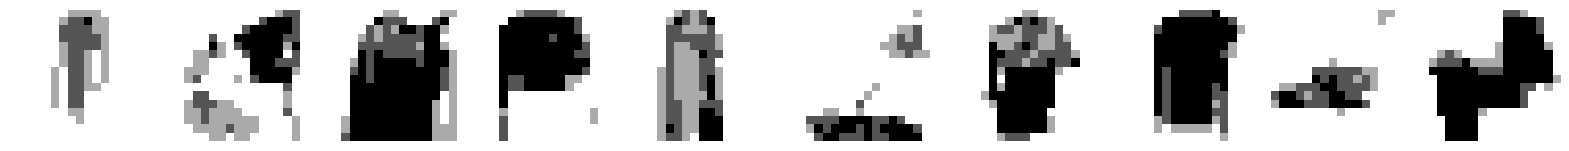

469/469 [==============================] - 30s 65ms/step - loss: 0.3327
Epoch 55/150
469/469 [==============================] - ETA: 0s - loss: 0.3326
Saved to ./output/generated_img_054.png


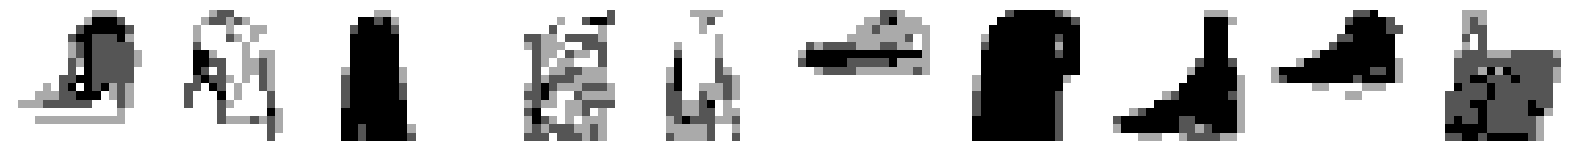

469/469 [==============================] - 31s 67ms/step - loss: 0.3326
Epoch 56/150
469/469 [==============================] - ETA: 0s - loss: 0.3321
Saved to ./output/generated_img_055.png


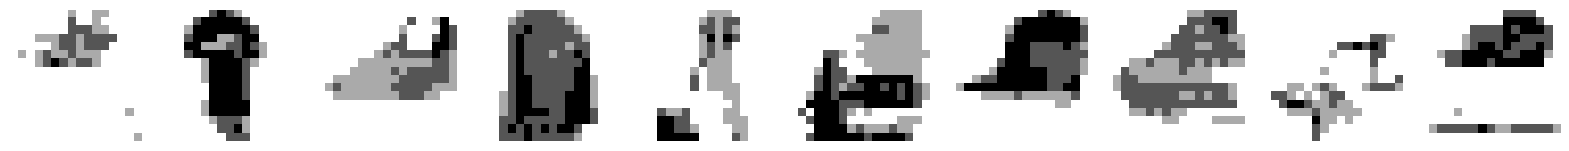

469/469 [==============================] - 29s 63ms/step - loss: 0.3321
Epoch 57/150
469/469 [==============================] - ETA: 0s - loss: 0.3321
Saved to ./output/generated_img_056.png


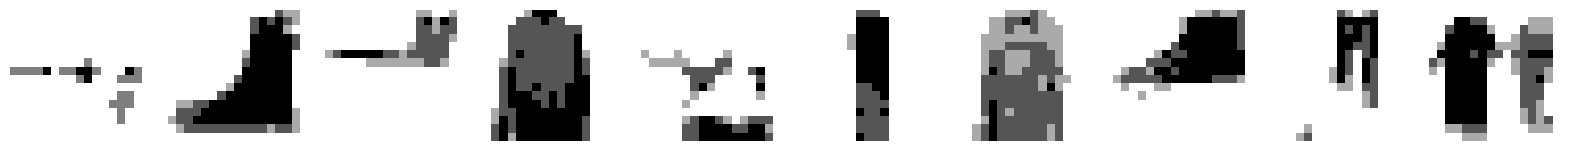

469/469 [==============================] - 31s 67ms/step - loss: 0.3321
Epoch 58/150
467/469 [============================>.] - ETA: 0s - loss: 0.3319
Saved to ./output/generated_img_057.png


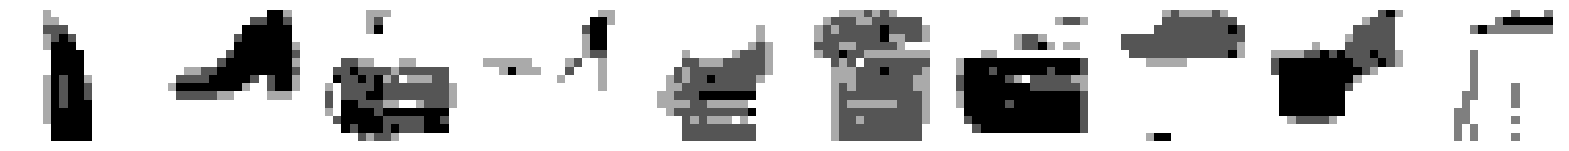

469/469 [==============================] - 29s 62ms/step - loss: 0.3318
Epoch 59/150
467/469 [============================>.] - ETA: 0s - loss: 0.3317
Saved to ./output/generated_img_058.png


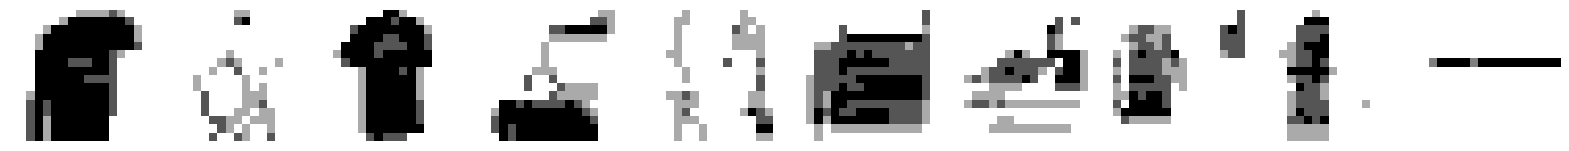

469/469 [==============================] - 31s 66ms/step - loss: 0.3317
Epoch 60/150
467/469 [============================>.] - ETA: 0s - loss: 0.3313
Saved to ./output/generated_img_059.png


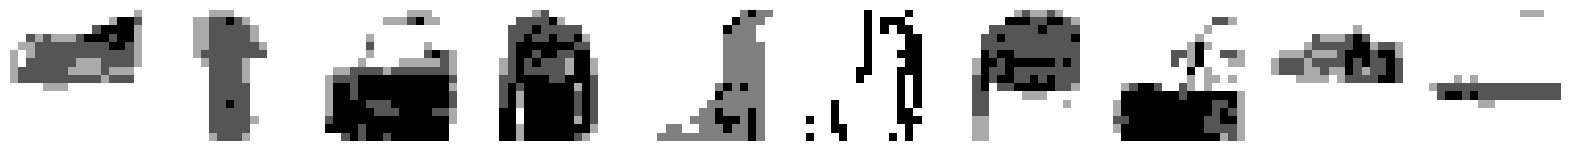

469/469 [==============================] - 32s 68ms/step - loss: 0.3313
Epoch 61/150
467/469 [============================>.] - ETA: 0s - loss: 0.3311
Saved to ./output/generated_img_060.png


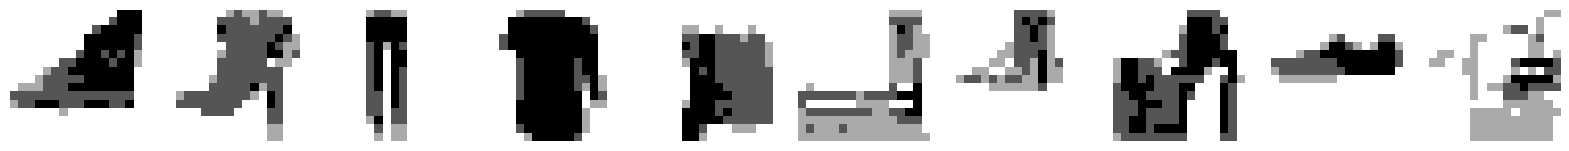

469/469 [==============================] - 29s 63ms/step - loss: 0.3311
Epoch 62/150
469/469 [==============================] - ETA: 0s - loss: 0.3310
Saved to ./output/generated_img_061.png


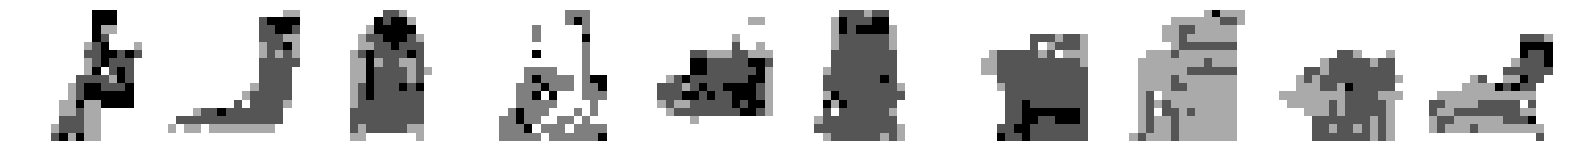

469/469 [==============================] - 31s 67ms/step - loss: 0.3310
Epoch 63/150
469/469 [==============================] - ETA: 0s - loss: 0.3308
Saved to ./output/generated_img_062.png


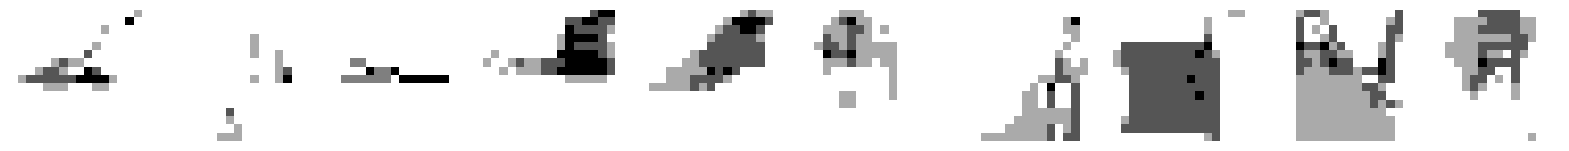

469/469 [==============================] - 30s 65ms/step - loss: 0.3308
Epoch 64/150
467/469 [============================>.] - ETA: 0s - loss: 0.3306
Saved to ./output/generated_img_063.png


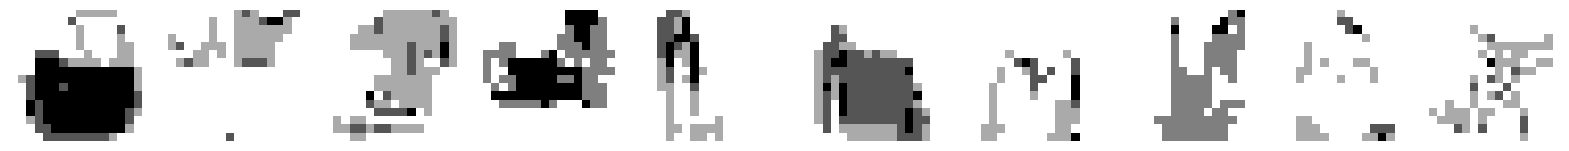

469/469 [==============================] - 29s 63ms/step - loss: 0.3306
Epoch 65/150
469/469 [==============================] - ETA: 0s - loss: 0.3304
Saved to ./output/generated_img_064.png


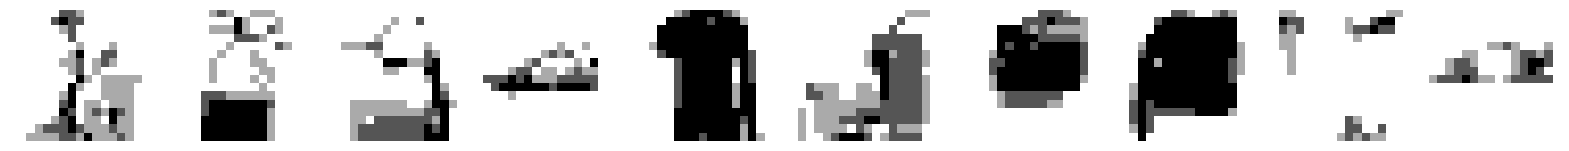

469/469 [==============================] - 30s 65ms/step - loss: 0.3304
Epoch 66/150
469/469 [==============================] - ETA: 0s - loss: 0.3303
Saved to ./output/generated_img_065.png


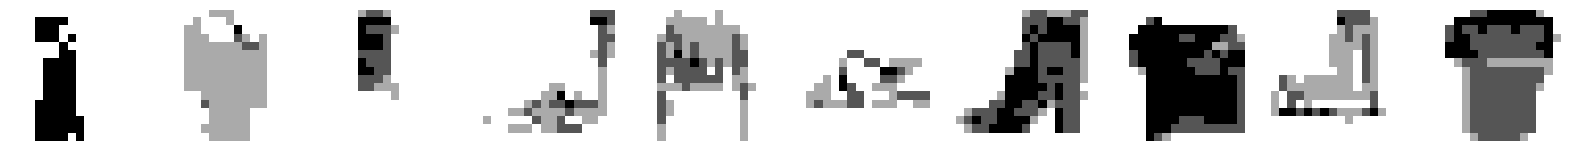

469/469 [==============================] - 30s 65ms/step - loss: 0.3303
Epoch 67/150
469/469 [==============================] - ETA: 0s - loss: 0.3301
Saved to ./output/generated_img_066.png


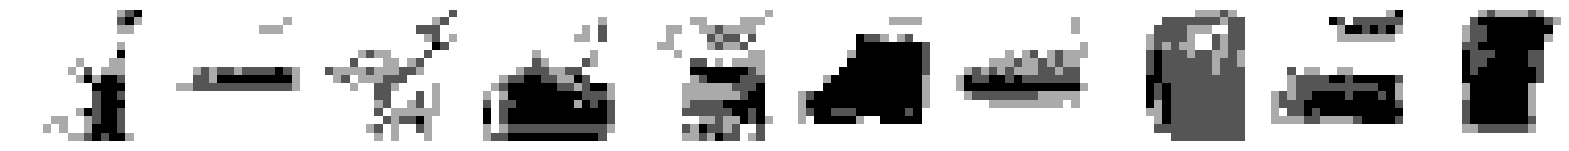

469/469 [==============================] - 30s 65ms/step - loss: 0.3301
Epoch 68/150
467/469 [============================>.] - ETA: 0s - loss: 0.3301
Saved to ./output/generated_img_067.png


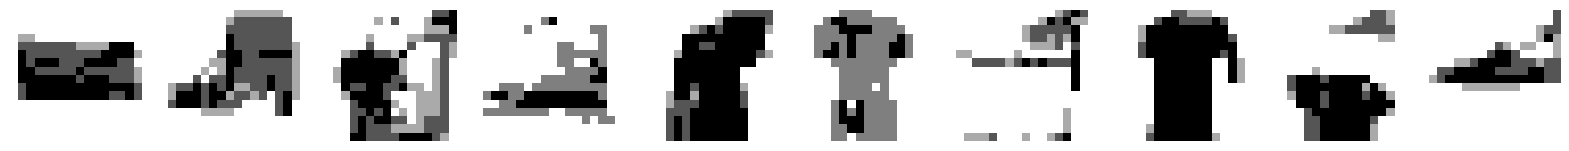

469/469 [==============================] - 32s 68ms/step - loss: 0.3301
Epoch 69/150
469/469 [==============================] - ETA: 0s - loss: 0.3296
Saved to ./output/generated_img_068.png


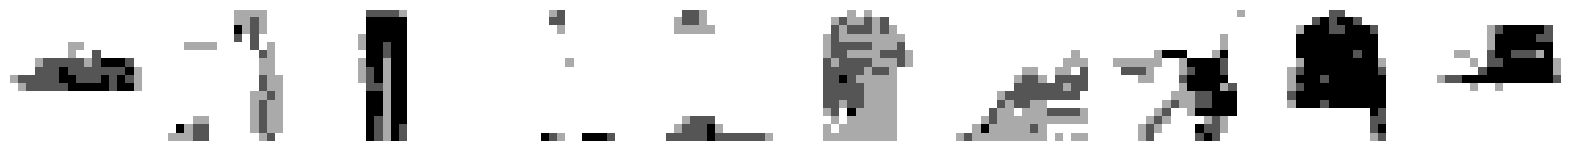

469/469 [==============================] - 30s 63ms/step - loss: 0.3296
Epoch 70/150
469/469 [==============================] - ETA: 0s - loss: 0.3296
Saved to ./output/generated_img_069.png


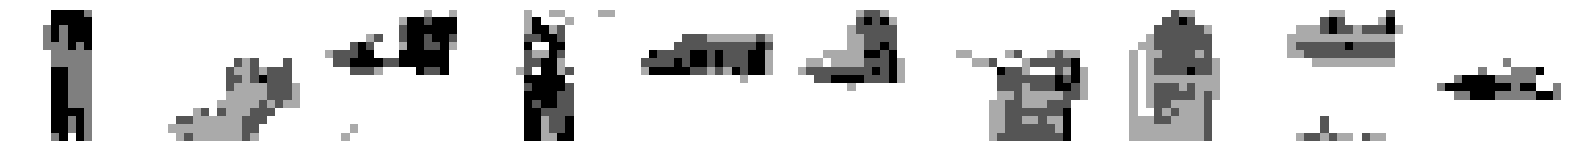

469/469 [==============================] - 30s 65ms/step - loss: 0.3296
Epoch 71/150
467/469 [============================>.] - ETA: 0s - loss: 0.3295
Saved to ./output/generated_img_070.png


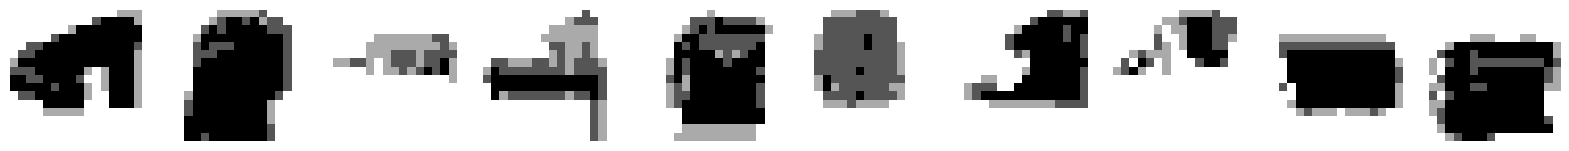

469/469 [==============================] - 31s 65ms/step - loss: 0.3294
Epoch 72/150
467/469 [============================>.] - ETA: 0s - loss: 0.3293
Saved to ./output/generated_img_071.png


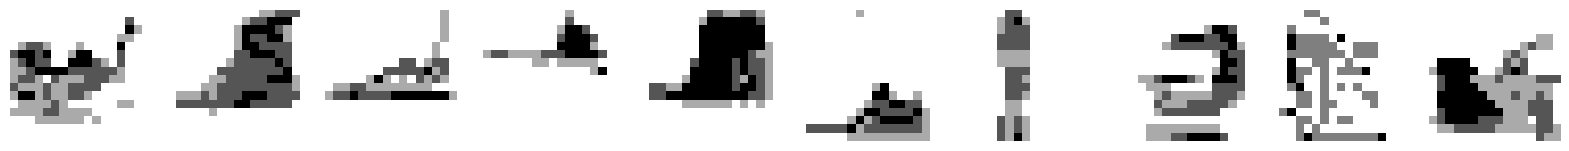

469/469 [==============================] - 30s 64ms/step - loss: 0.3293
Epoch 73/150
467/469 [============================>.] - ETA: 0s - loss: 0.3292
Saved to ./output/generated_img_072.png


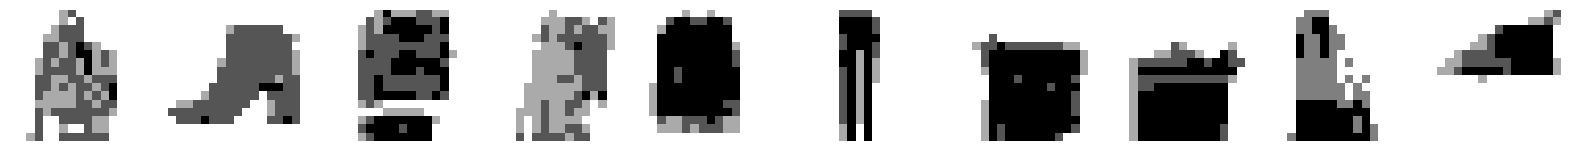

469/469 [==============================] - 30s 65ms/step - loss: 0.3291
Epoch 74/150
469/469 [==============================] - ETA: 0s - loss: 0.3291
Saved to ./output/generated_img_073.png


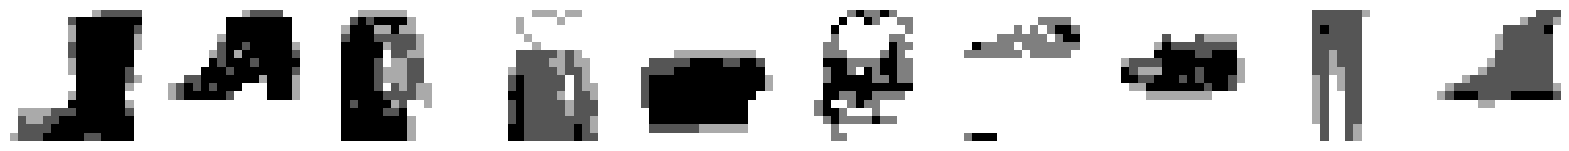

469/469 [==============================] - 30s 64ms/step - loss: 0.3291
Epoch 75/150
469/469 [==============================] - ETA: 0s - loss: 0.3287
Saved to ./output/generated_img_074.png


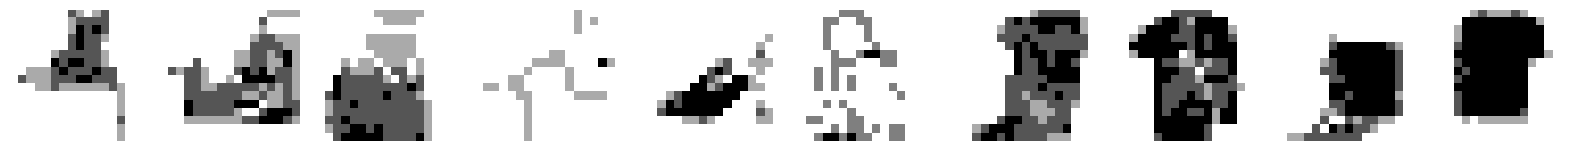

469/469 [==============================] - 31s 67ms/step - loss: 0.3287
Epoch 76/150
469/469 [==============================] - ETA: 0s - loss: 0.3288
Saved to ./output/generated_img_075.png


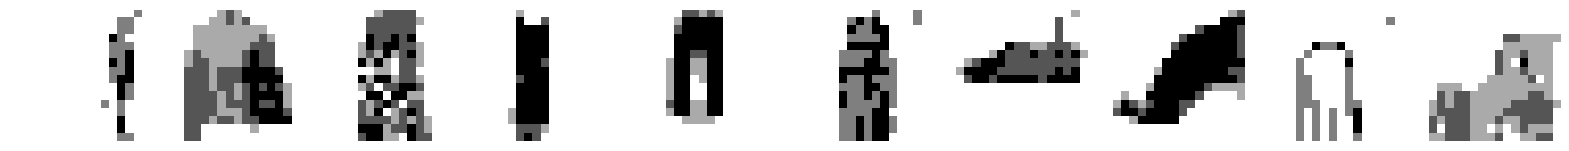

469/469 [==============================] - 30s 65ms/step - loss: 0.3288
Epoch 77/150
467/469 [============================>.] - ETA: 0s - loss: 0.3285
Saved to ./output/generated_img_076.png


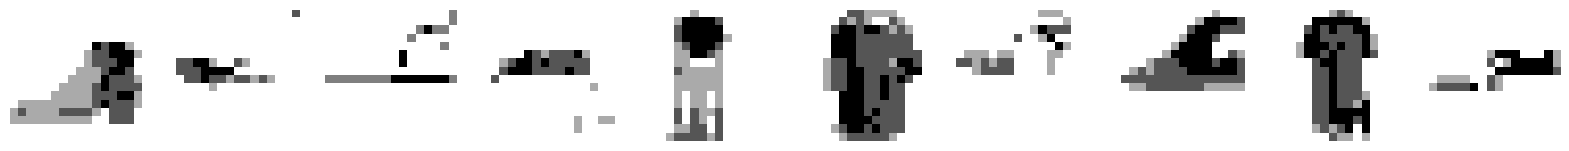

469/469 [==============================] - 29s 63ms/step - loss: 0.3285
Epoch 78/150
469/469 [==============================] - ETA: 0s - loss: 0.3283
Saved to ./output/generated_img_077.png


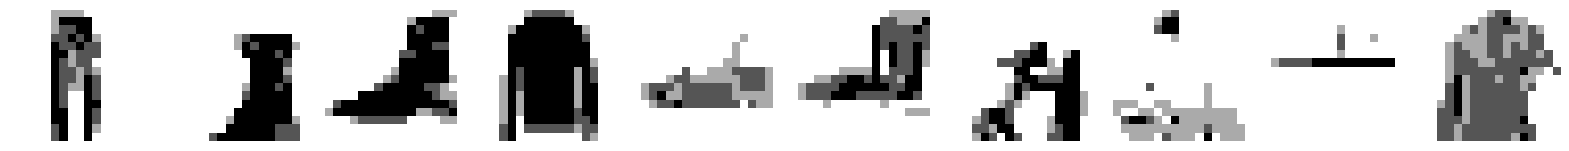

469/469 [==============================] - 31s 66ms/step - loss: 0.3283
Epoch 79/150
469/469 [==============================] - ETA: 0s - loss: 0.3282
Saved to ./output/generated_img_078.png


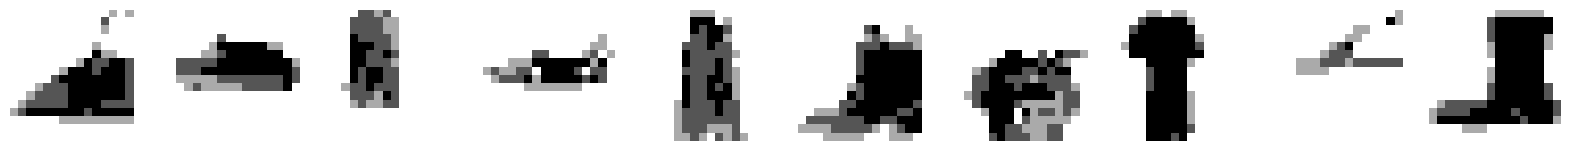

469/469 [==============================] - 31s 66ms/step - loss: 0.3282
Epoch 80/150
467/469 [============================>.] - ETA: 0s - loss: 0.3282
Saved to ./output/generated_img_079.png


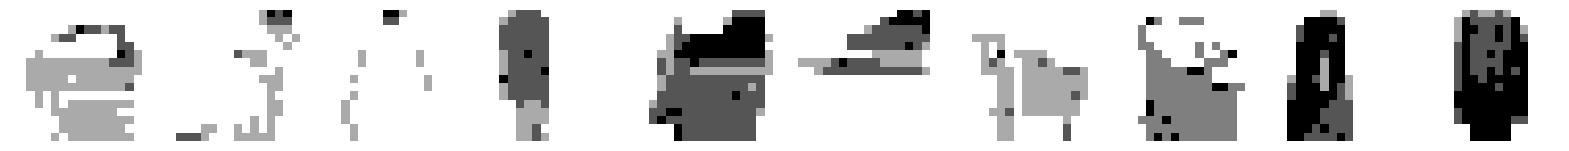

469/469 [==============================] - 31s 65ms/step - loss: 0.3281
Epoch 81/150
469/469 [==============================] - ETA: 0s - loss: 0.3282
Saved to ./output/generated_img_080.png


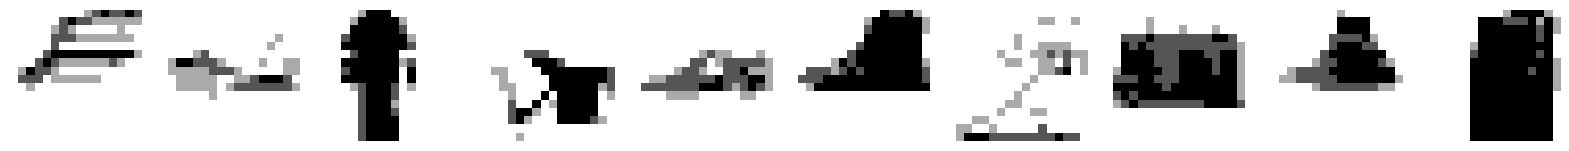

469/469 [==============================] - 30s 64ms/step - loss: 0.3282
Epoch 82/150
469/469 [==============================] - ETA: 0s - loss: 0.3277
Saved to ./output/generated_img_081.png


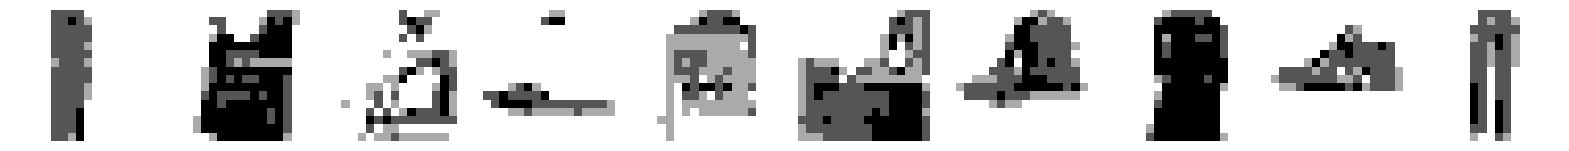

469/469 [==============================] - 31s 65ms/step - loss: 0.3277
Epoch 83/150
469/469 [==============================] - ETA: 0s - loss: 0.3278
Saved to ./output/generated_img_082.png


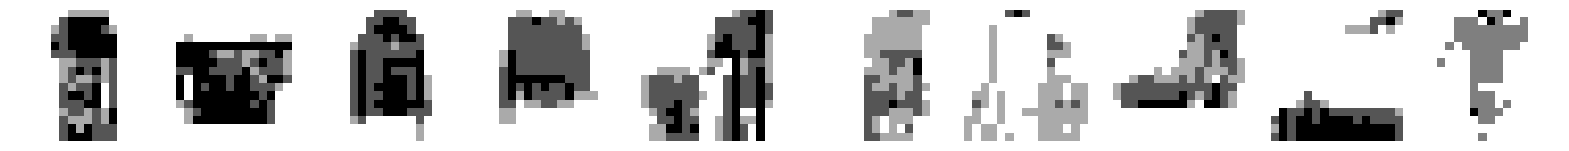

469/469 [==============================] - 31s 66ms/step - loss: 0.3278
Epoch 84/150
469/469 [==============================] - ETA: 0s - loss: 0.3276
Saved to ./output/generated_img_083.png


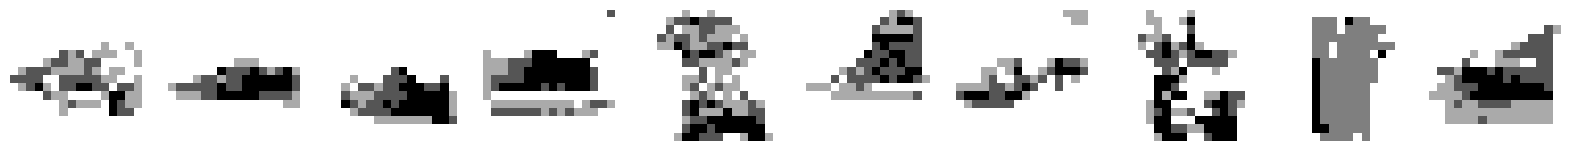

469/469 [==============================] - 30s 64ms/step - loss: 0.3276
Epoch 85/150
469/469 [==============================] - ETA: 0s - loss: 0.3276
Saved to ./output/generated_img_084.png


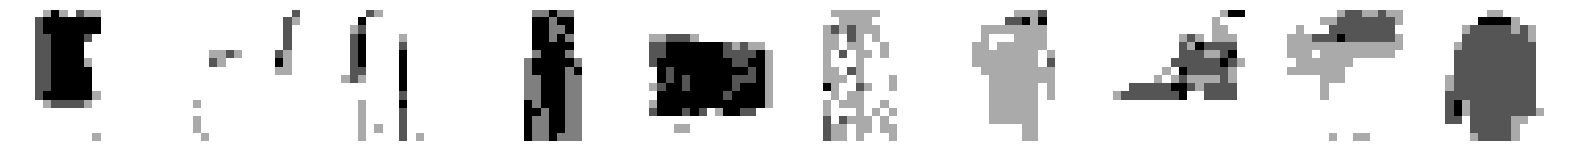

469/469 [==============================] - 31s 65ms/step - loss: 0.3276
Epoch 86/150
467/469 [============================>.] - ETA: 0s - loss: 0.3272
Saved to ./output/generated_img_085.png


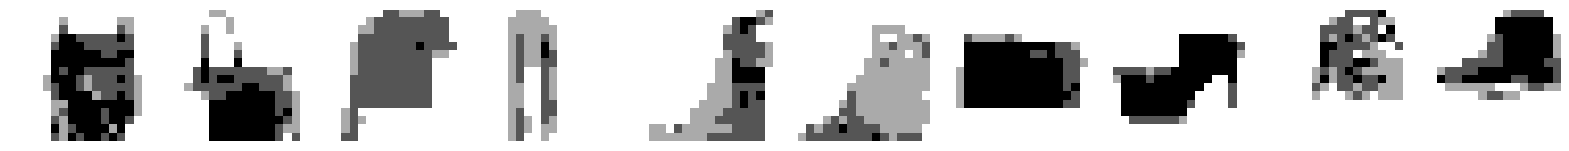

469/469 [==============================] - 30s 65ms/step - loss: 0.3272
Epoch 87/150
467/469 [============================>.] - ETA: 0s - loss: 0.3271
Saved to ./output/generated_img_086.png


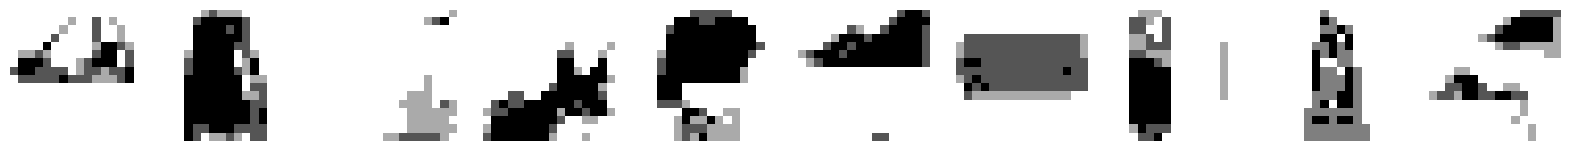

469/469 [==============================] - 30s 65ms/step - loss: 0.3271
Epoch 88/150
469/469 [==============================] - ETA: 0s - loss: 0.3272
Saved to ./output/generated_img_087.png


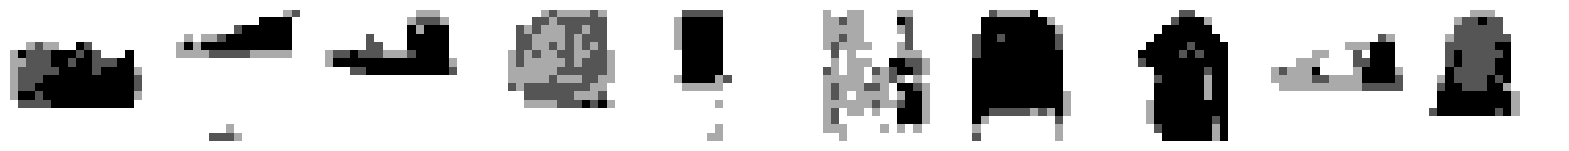

469/469 [==============================] - 32s 68ms/step - loss: 0.3272
Epoch 89/150
467/469 [============================>.] - ETA: 0s - loss: 0.3271
Saved to ./output/generated_img_088.png


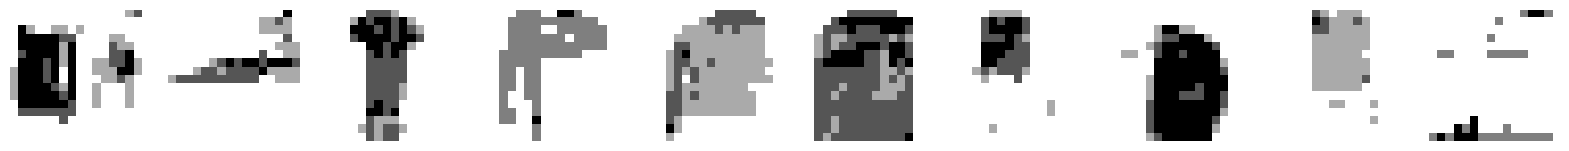

469/469 [==============================] - 30s 63ms/step - loss: 0.3271
Epoch 90/150
467/469 [============================>.] - ETA: 0s - loss: 0.3269
Saved to ./output/generated_img_089.png


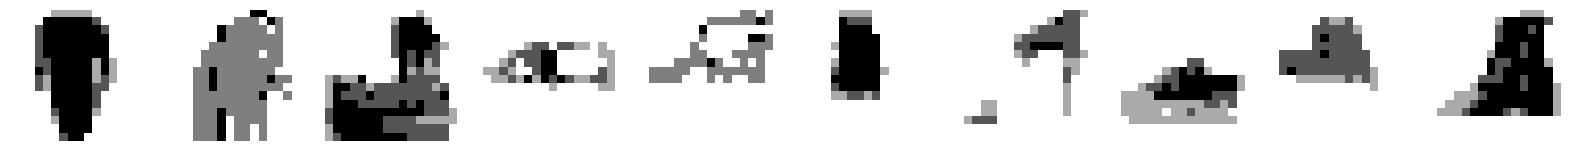

469/469 [==============================] - 31s 66ms/step - loss: 0.3268
Epoch 91/150
467/469 [============================>.] - ETA: 0s - loss: 0.3266
Saved to ./output/generated_img_090.png


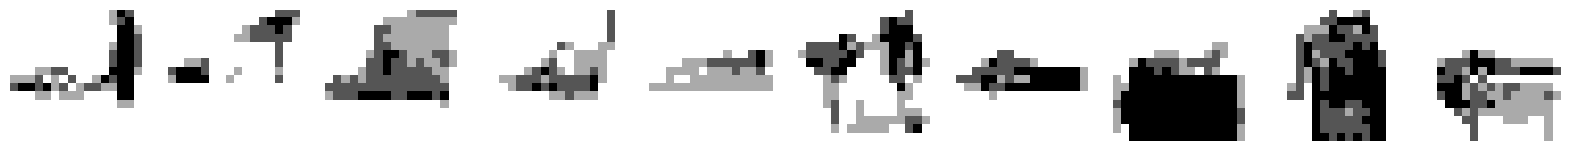

469/469 [==============================] - 31s 65ms/step - loss: 0.3266
Epoch 92/150
469/469 [==============================] - ETA: 0s - loss: 0.3266
Saved to ./output/generated_img_091.png


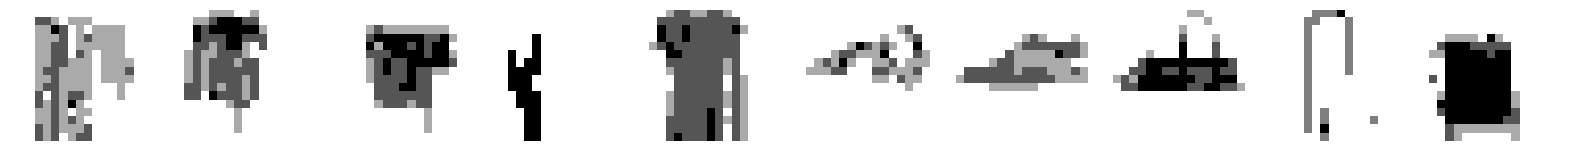

469/469 [==============================] - 30s 65ms/step - loss: 0.3266
Epoch 93/150
469/469 [==============================] - ETA: 0s - loss: 0.3266
Saved to ./output/generated_img_092.png


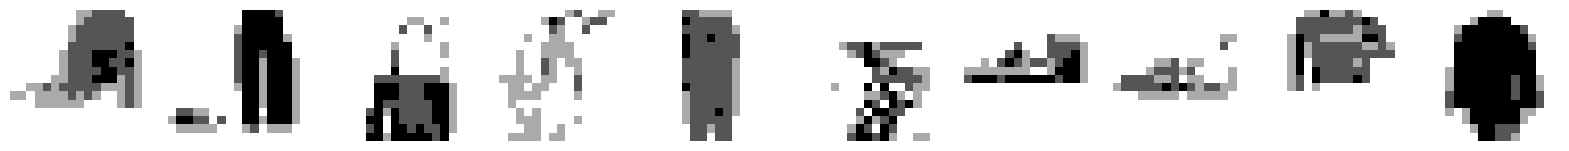

469/469 [==============================] - 31s 66ms/step - loss: 0.3266
Epoch 94/150
469/469 [==============================] - ETA: 0s - loss: 0.3264
Saved to ./output/generated_img_093.png


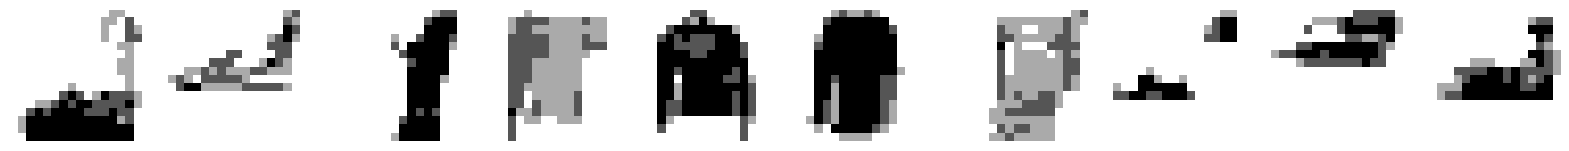

469/469 [==============================] - 31s 66ms/step - loss: 0.3264
Epoch 95/150
469/469 [==============================] - ETA: 0s - loss: 0.3263
Saved to ./output/generated_img_094.png


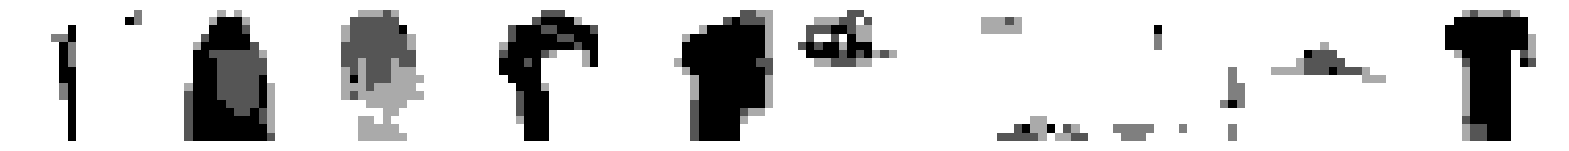

469/469 [==============================] - 31s 65ms/step - loss: 0.3263
Epoch 96/150
469/469 [==============================] - ETA: 0s - loss: 0.3264
Saved to ./output/generated_img_095.png


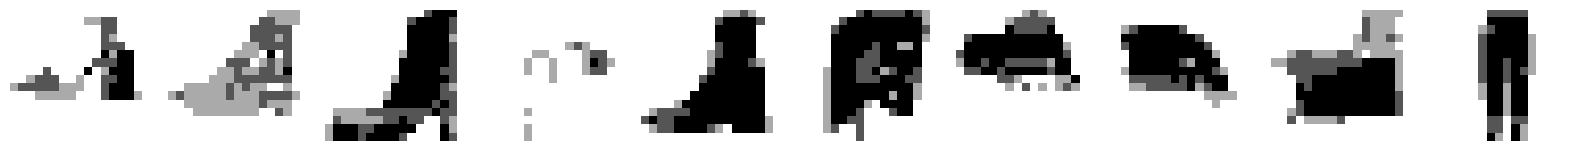

469/469 [==============================] - 31s 65ms/step - loss: 0.3264
Epoch 97/150
467/469 [============================>.] - ETA: 0s - loss: 0.3261
Saved to ./output/generated_img_096.png


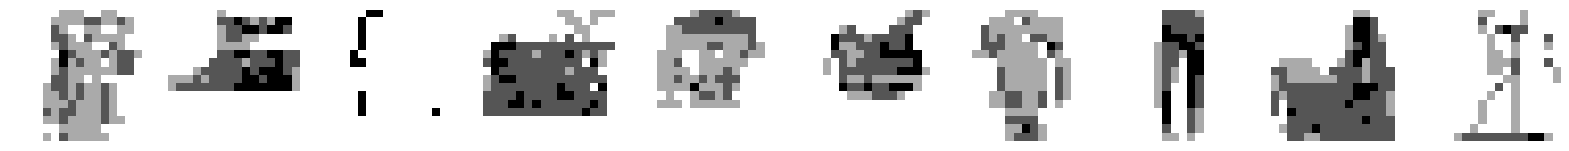

469/469 [==============================] - 30s 64ms/step - loss: 0.3261
Epoch 98/150
469/469 [==============================] - ETA: 0s - loss: 0.3258
Saved to ./output/generated_img_097.png


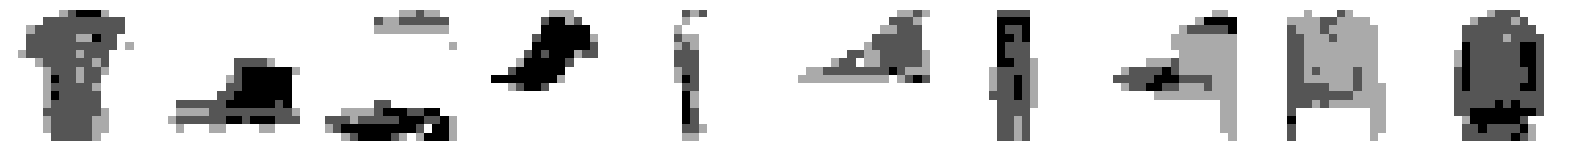

469/469 [==============================] - 30s 64ms/step - loss: 0.3258
Epoch 99/150
469/469 [==============================] - ETA: 0s - loss: 0.3258
Saved to ./output/generated_img_098.png


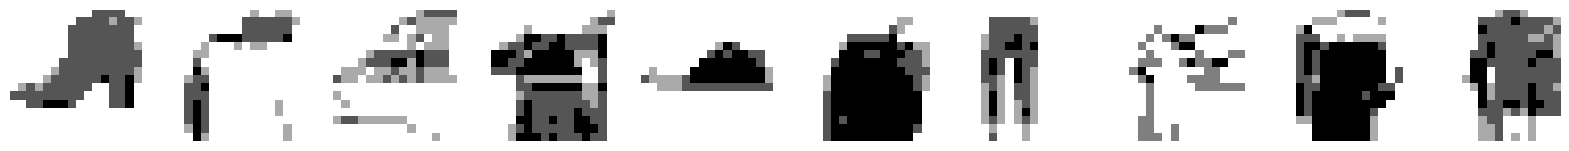

469/469 [==============================] - 31s 65ms/step - loss: 0.3258
Epoch 100/150
467/469 [============================>.] - ETA: 0s - loss: 0.3256
Saved to ./output/generated_img_099.png


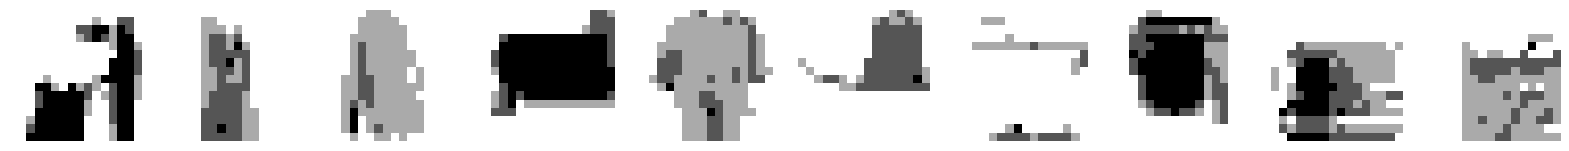

469/469 [==============================] - 30s 64ms/step - loss: 0.3257
Epoch 101/150
467/469 [============================>.] - ETA: 0s - loss: 0.3257
Saved to ./output/generated_img_100.png


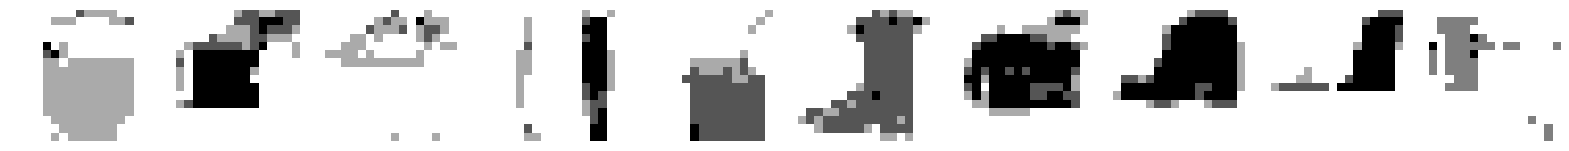

469/469 [==============================] - 32s 69ms/step - loss: 0.3257
Epoch 102/150
467/469 [============================>.] - ETA: 0s - loss: 0.3255
Saved to ./output/generated_img_101.png


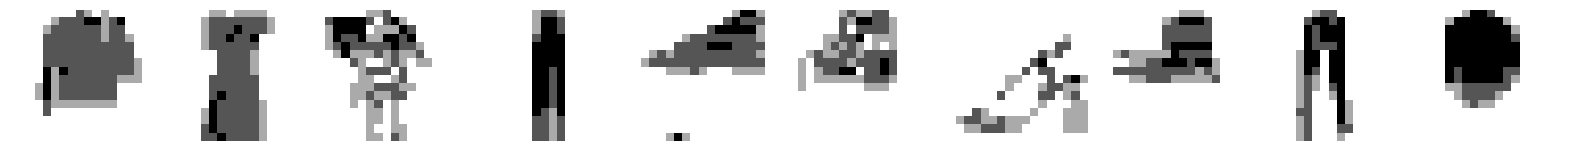

469/469 [==============================] - 30s 64ms/step - loss: 0.3255
Epoch 103/150
467/469 [============================>.] - ETA: 0s - loss: 0.3255
Saved to ./output/generated_img_102.png


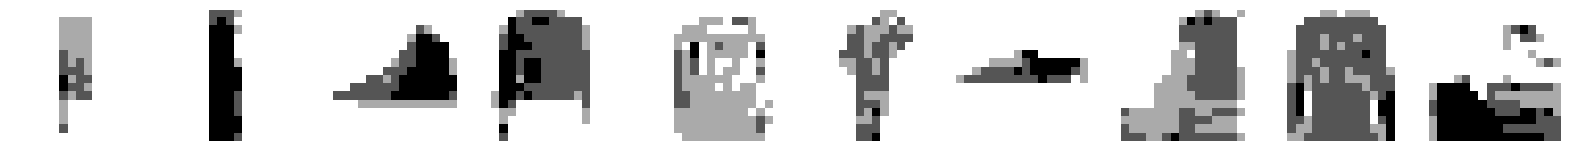

469/469 [==============================] - 30s 65ms/step - loss: 0.3255
Epoch 104/150
469/469 [==============================] - ETA: 0s - loss: 0.3253
Saved to ./output/generated_img_103.png


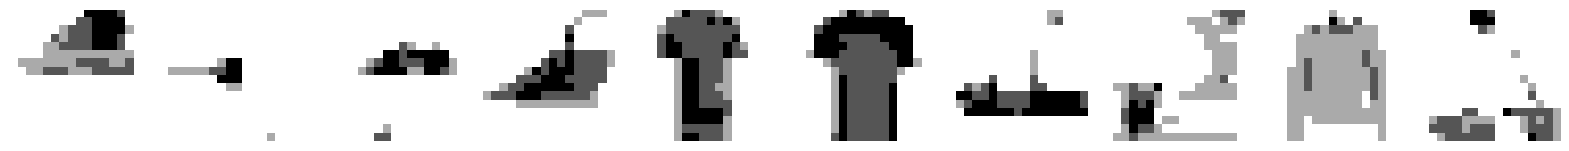

469/469 [==============================] - 31s 65ms/step - loss: 0.3253
Epoch 105/150
469/469 [==============================] - ETA: 0s - loss: 0.3253
Saved to ./output/generated_img_104.png


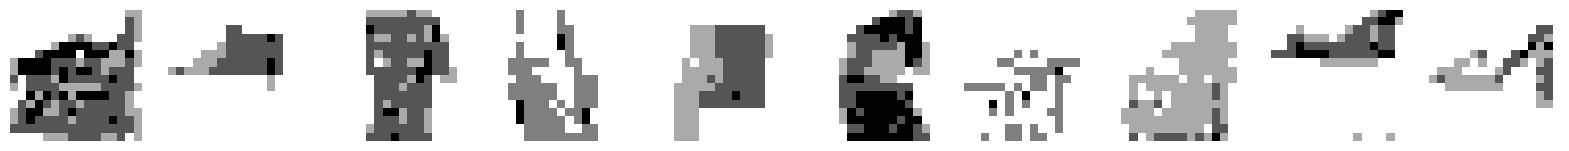

469/469 [==============================] - 29s 62ms/step - loss: 0.3253
Epoch 106/150
467/469 [============================>.] - ETA: 0s - loss: 0.3251
Saved to ./output/generated_img_105.png


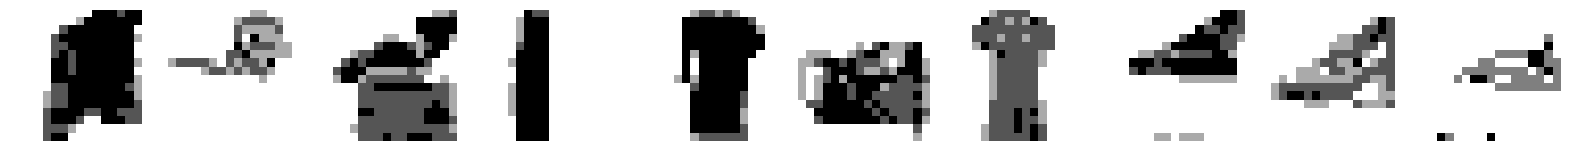

469/469 [==============================] - 31s 66ms/step - loss: 0.3252
Epoch 107/150
467/469 [============================>.] - ETA: 0s - loss: 0.3251
Saved to ./output/generated_img_106.png


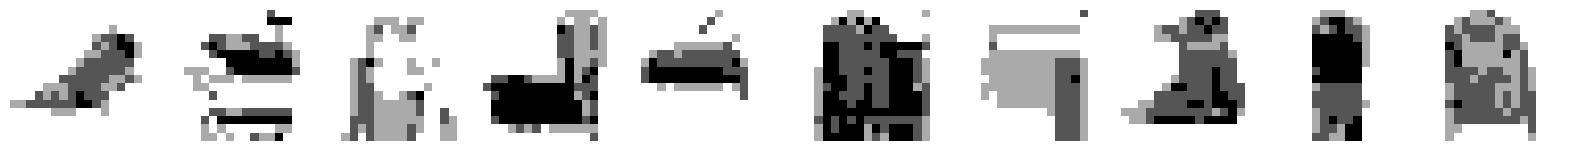

469/469 [==============================] - 31s 67ms/step - loss: 0.3251
Epoch 108/150
467/469 [============================>.] - ETA: 0s - loss: 0.3250
Saved to ./output/generated_img_107.png


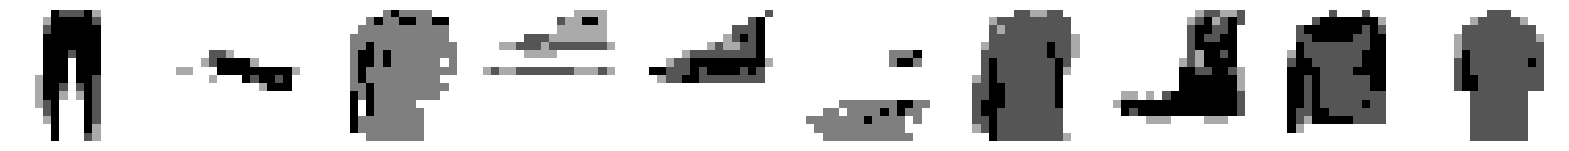

469/469 [==============================] - 29s 63ms/step - loss: 0.3250
Epoch 109/150
469/469 [==============================] - ETA: 0s - loss: 0.3249
Saved to ./output/generated_img_108.png


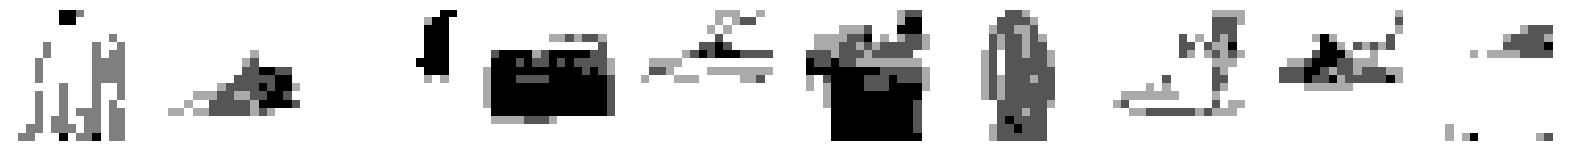

469/469 [==============================] - 32s 67ms/step - loss: 0.3249
Epoch 110/150
469/469 [==============================] - ETA: 0s - loss: 0.3248
Saved to ./output/generated_img_109.png


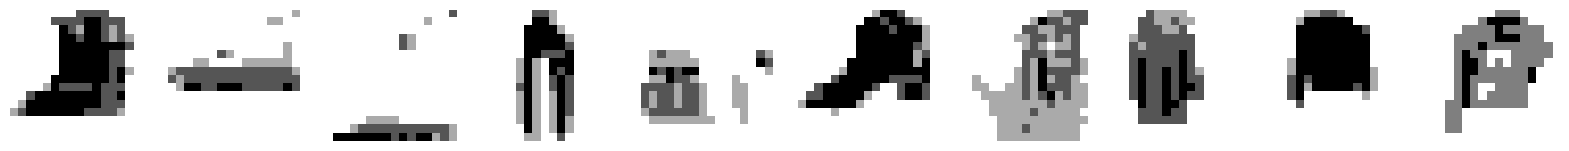

469/469 [==============================] - 29s 63ms/step - loss: 0.3248
Epoch 111/150
469/469 [==============================] - ETA: 0s - loss: 0.3246
Saved to ./output/generated_img_110.png


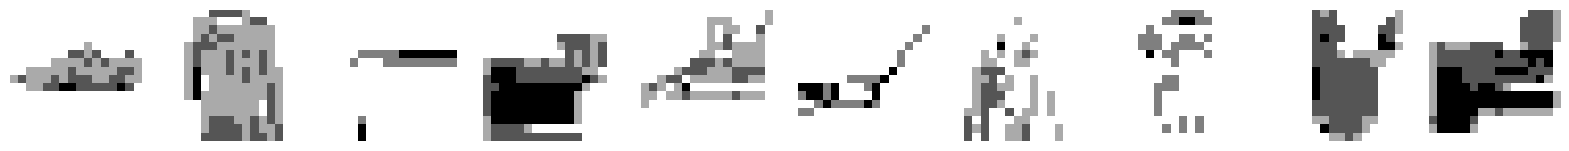

469/469 [==============================] - 31s 65ms/step - loss: 0.3246
Epoch 112/150
469/469 [==============================] - ETA: 0s - loss: 0.3246
Saved to ./output/generated_img_111.png


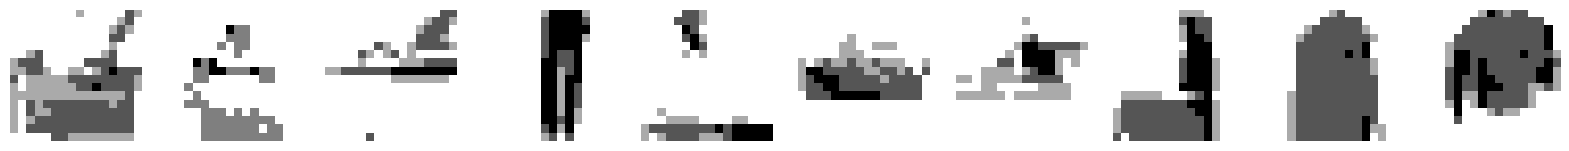

469/469 [==============================] - 31s 66ms/step - loss: 0.3246
Epoch 113/150
469/469 [==============================] - ETA: 0s - loss: 0.3244
Saved to ./output/generated_img_112.png


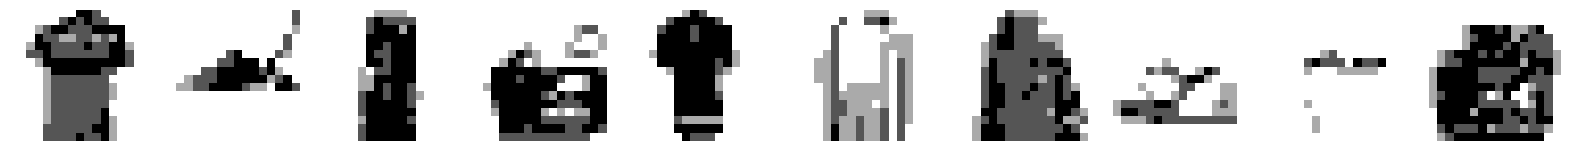

469/469 [==============================] - 30s 64ms/step - loss: 0.3244
Epoch 114/150
467/469 [============================>.] - ETA: 0s - loss: 0.3246
Saved to ./output/generated_img_113.png


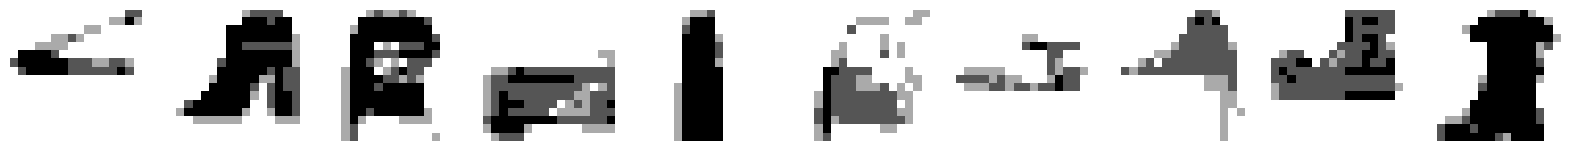

469/469 [==============================] - 32s 69ms/step - loss: 0.3246
Epoch 115/150
467/469 [============================>.] - ETA: 0s - loss: 0.3243
Saved to ./output/generated_img_114.png


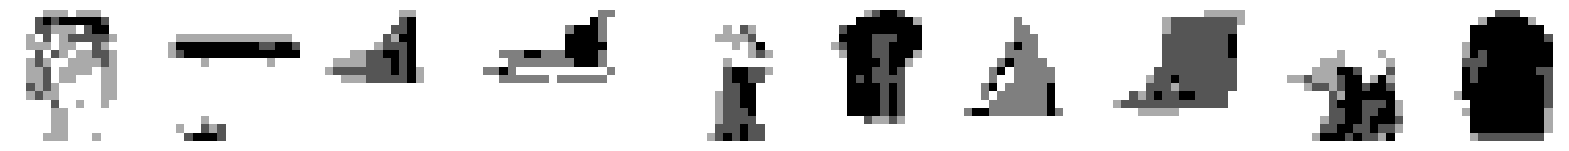

469/469 [==============================] - 30s 64ms/step - loss: 0.3243
Epoch 116/150
469/469 [==============================] - ETA: 0s - loss: 0.3242
Saved to ./output/generated_img_115.png


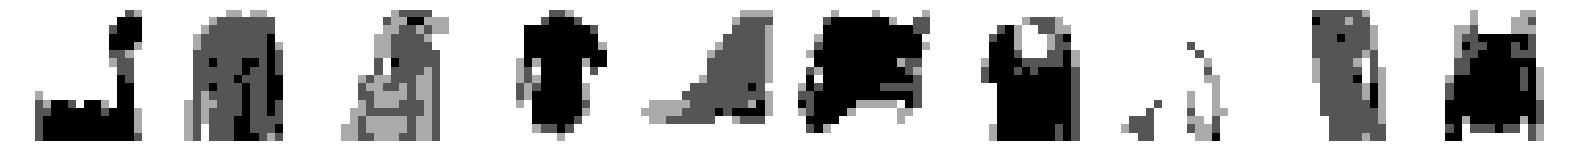

469/469 [==============================] - 30s 63ms/step - loss: 0.3242
Epoch 117/150
469/469 [==============================] - ETA: 0s - loss: 0.3243
Saved to ./output/generated_img_116.png


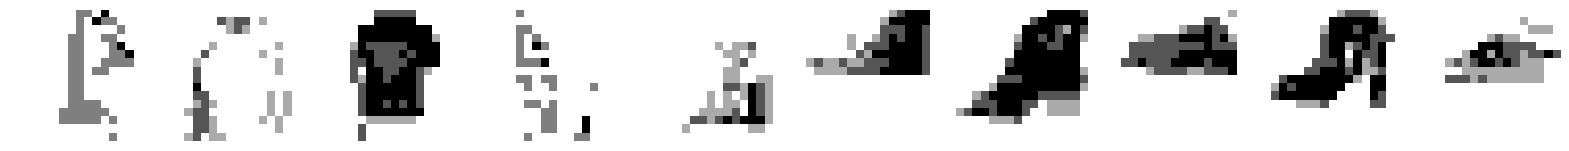

469/469 [==============================] - 33s 69ms/step - loss: 0.3243
Epoch 118/150
469/469 [==============================] - ETA: 0s - loss: 0.3241
Saved to ./output/generated_img_117.png


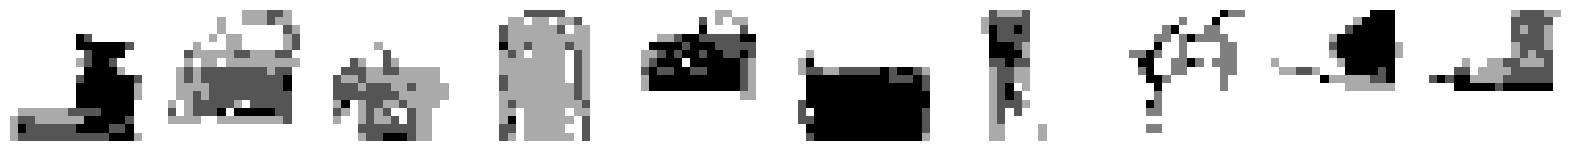

469/469 [==============================] - 31s 66ms/step - loss: 0.3241
Epoch 119/150
467/469 [============================>.] - ETA: 0s - loss: 0.3238
Saved to ./output/generated_img_118.png


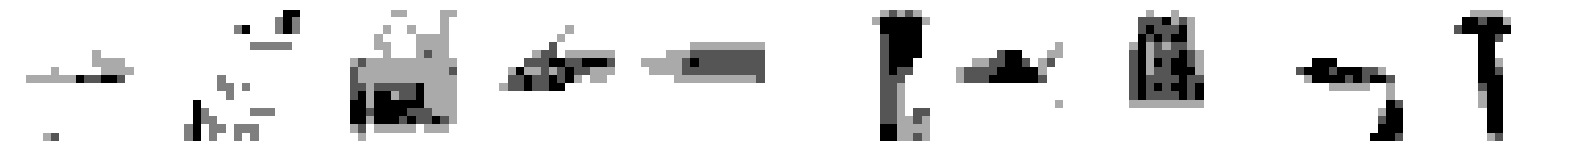

469/469 [==============================] - 31s 67ms/step - loss: 0.3238
Epoch 120/150
469/469 [==============================] - ETA: 0s - loss: 0.3240
Saved to ./output/generated_img_119.png


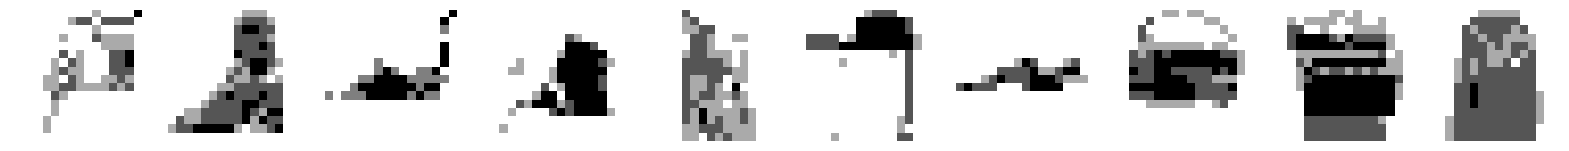

469/469 [==============================] - 31s 66ms/step - loss: 0.3240
Epoch 121/150
469/469 [==============================] - ETA: 0s - loss: 0.3238
Saved to ./output/generated_img_120.png


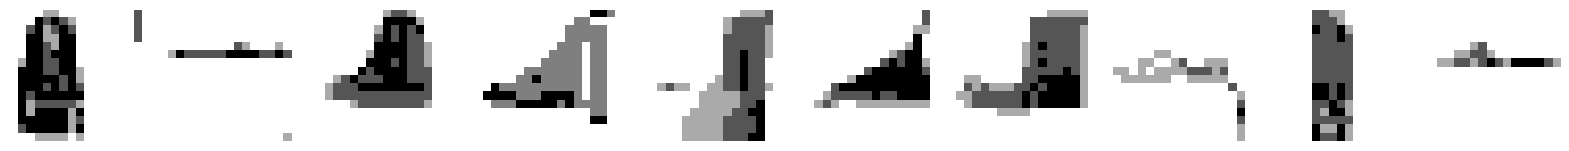

469/469 [==============================] - 30s 65ms/step - loss: 0.3238
Epoch 122/150
469/469 [==============================] - ETA: 0s - loss: 0.3236
Saved to ./output/generated_img_121.png


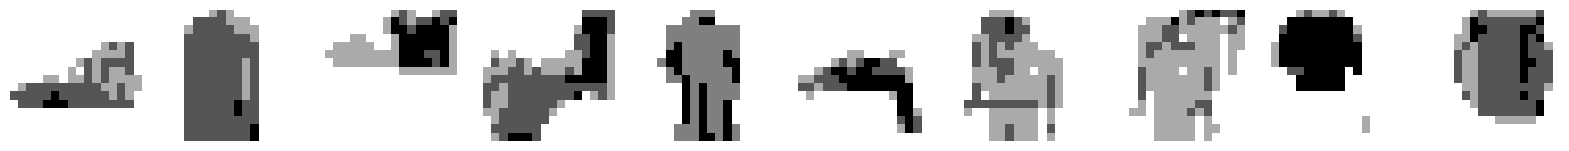

469/469 [==============================] - 32s 68ms/step - loss: 0.3236
Epoch 123/150
469/469 [==============================] - ETA: 0s - loss: 0.3237
Saved to ./output/generated_img_122.png


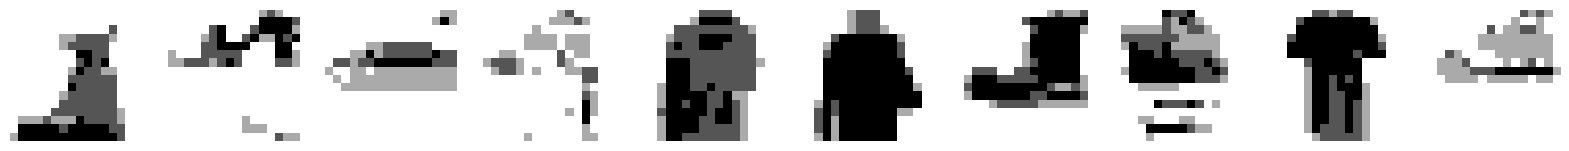

469/469 [==============================] - 30s 65ms/step - loss: 0.3237
Epoch 124/150
469/469 [==============================] - ETA: 0s - loss: 0.3236
Saved to ./output/generated_img_123.png


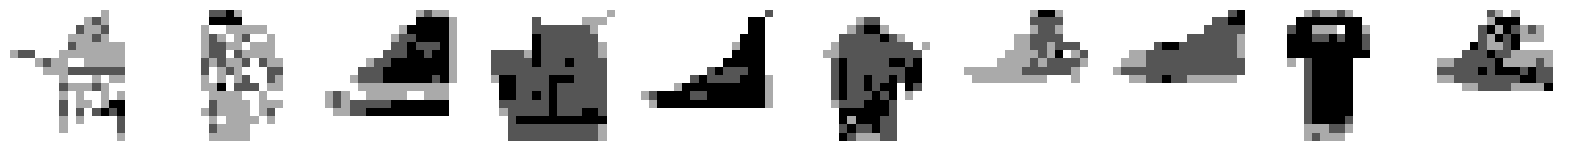

469/469 [==============================] - 31s 67ms/step - loss: 0.3236
Epoch 125/150
469/469 [==============================] - ETA: 0s - loss: 0.3235
Saved to ./output/generated_img_124.png


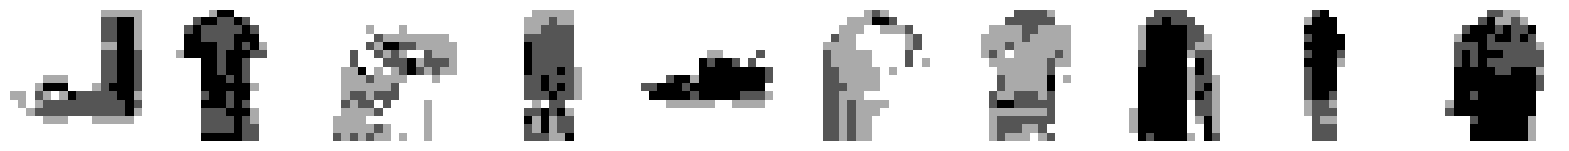

469/469 [==============================] - 31s 67ms/step - loss: 0.3235
Epoch 126/150
467/469 [============================>.] - ETA: 0s - loss: 0.3234
Saved to ./output/generated_img_125.png


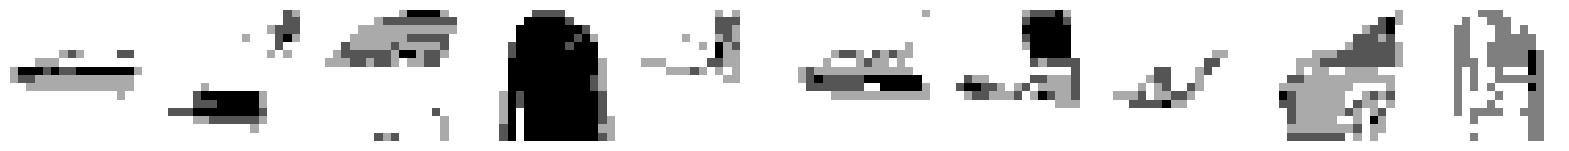

469/469 [==============================] - 30s 65ms/step - loss: 0.3234
Epoch 127/150
469/469 [==============================] - ETA: 0s - loss: 0.3234
Saved to ./output/generated_img_126.png


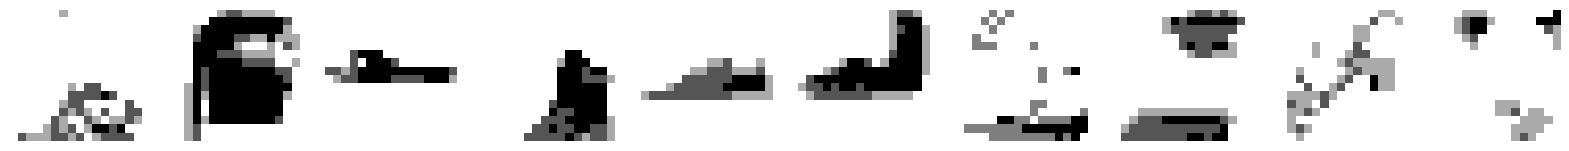

469/469 [==============================] - 33s 70ms/step - loss: 0.3234
Epoch 128/150
468/469 [============================>.] - ETA: 0s - loss: 0.3233
Saved to ./output/generated_img_127.png


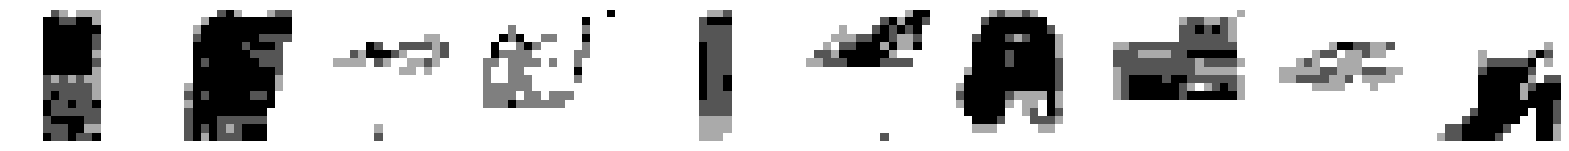

469/469 [==============================] - 37s 79ms/step - loss: 0.3233
Epoch 129/150
469/469 [==============================] - ETA: 0s - loss: 0.3231
Saved to ./output/generated_img_128.png


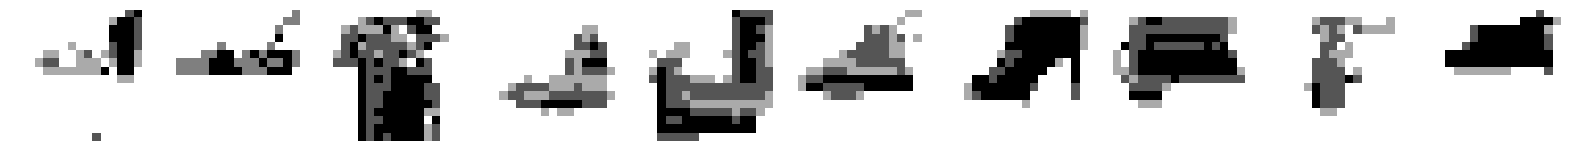

469/469 [==============================] - 32s 68ms/step - loss: 0.3231
Epoch 130/150
468/469 [============================>.] - ETA: 0s - loss: 0.3231
Saved to ./output/generated_img_129.png


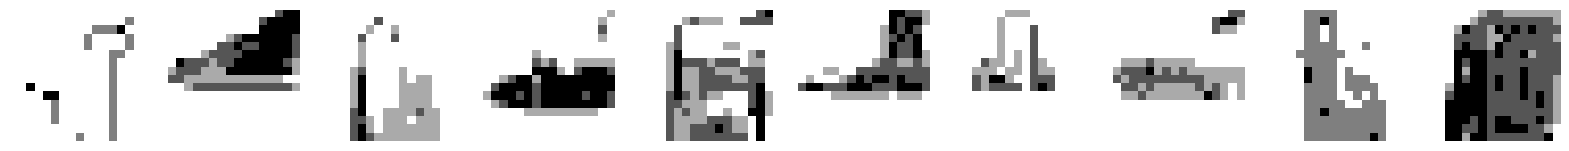

469/469 [==============================] - 34s 72ms/step - loss: 0.3231
Epoch 131/150
469/469 [==============================] - ETA: 0s - loss: 0.3230
Saved to ./output/generated_img_130.png


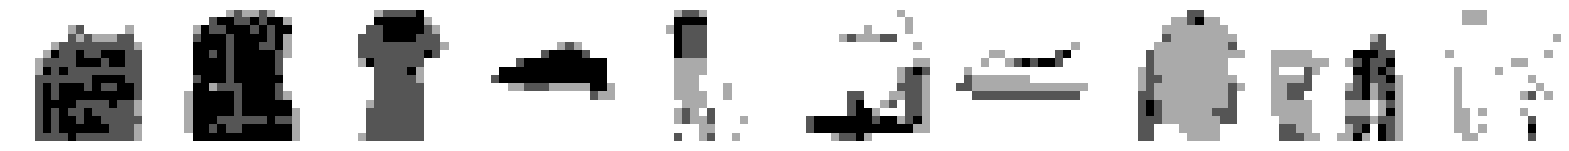

469/469 [==============================] - 32s 67ms/step - loss: 0.3230
Epoch 132/150
469/469 [==============================] - ETA: 0s - loss: 0.3230
Saved to ./output/generated_img_131.png


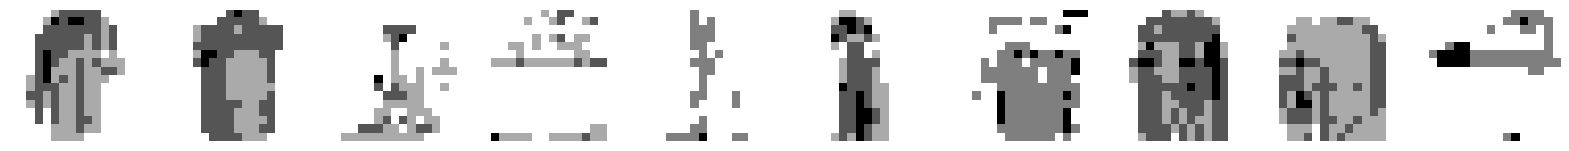

469/469 [==============================] - 33s 70ms/step - loss: 0.3230
Epoch 133/150
469/469 [==============================] - ETA: 0s - loss: 0.3232
Saved to ./output/generated_img_132.png


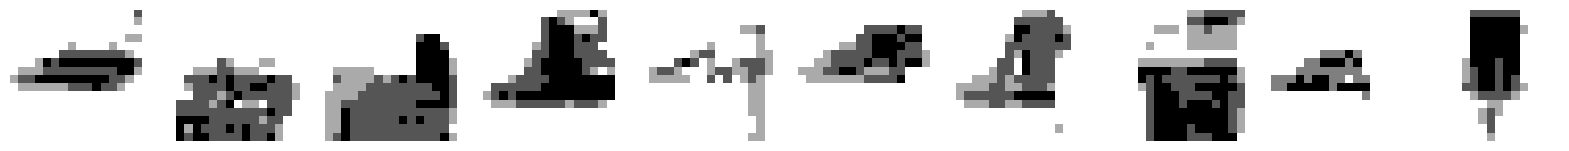

469/469 [==============================] - 32s 68ms/step - loss: 0.3232
Epoch 134/150
467/469 [============================>.] - ETA: 0s - loss: 0.3228
Saved to ./output/generated_img_133.png


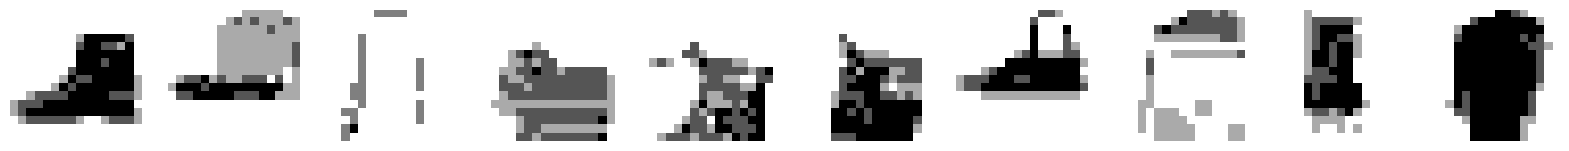

469/469 [==============================] - 31s 67ms/step - loss: 0.3228
Epoch 135/150
467/469 [============================>.] - ETA: 0s - loss: 0.3227
Saved to ./output/generated_img_134.png


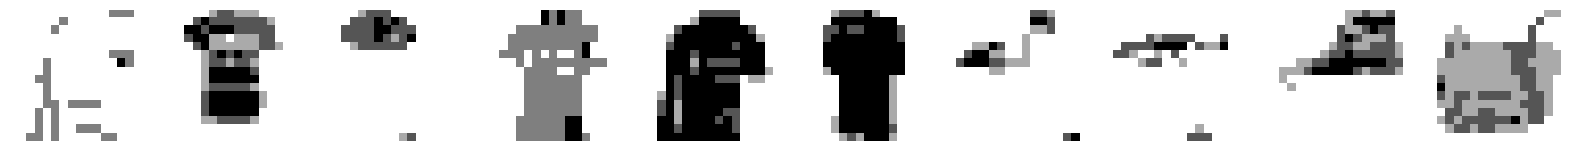

469/469 [==============================] - 31s 66ms/step - loss: 0.3227
Epoch 136/150
469/469 [==============================] - ETA: 0s - loss: 0.3227
Saved to ./output/generated_img_135.png


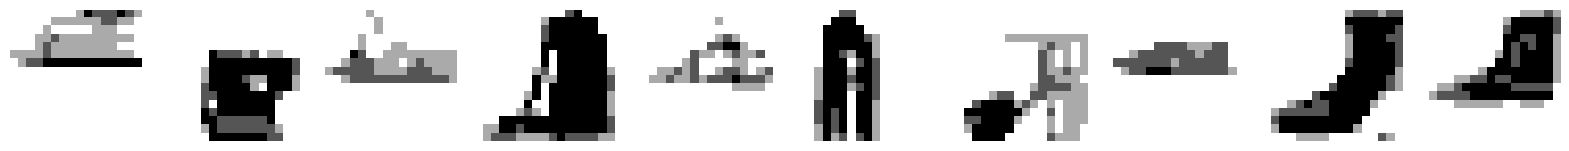

469/469 [==============================] - 31s 66ms/step - loss: 0.3227
Epoch 137/150
469/469 [==============================] - ETA: 0s - loss: 0.3227
Saved to ./output/generated_img_136.png


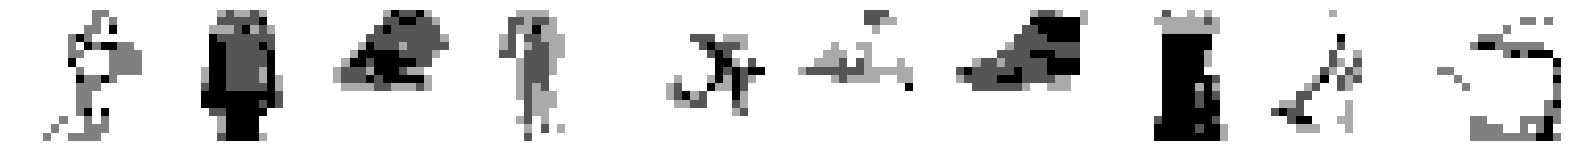

469/469 [==============================] - 30s 65ms/step - loss: 0.3227
Epoch 138/150
469/469 [==============================] - ETA: 0s - loss: 0.3225
Saved to ./output/generated_img_137.png


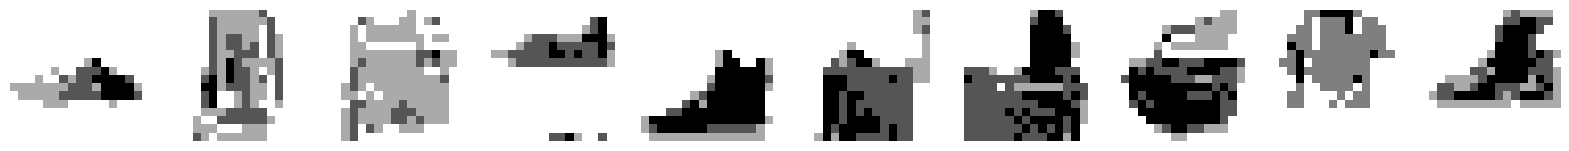

469/469 [==============================] - 32s 67ms/step - loss: 0.3225
Epoch 139/150
467/469 [============================>.] - ETA: 0s - loss: 0.3225
Saved to ./output/generated_img_138.png


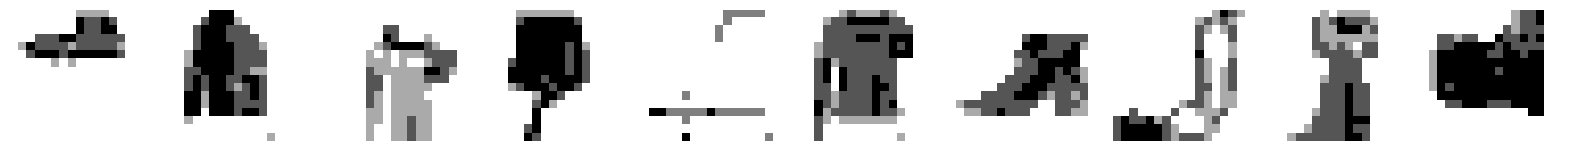

469/469 [==============================] - 32s 69ms/step - loss: 0.3225
Epoch 140/150
469/469 [==============================] - ETA: 0s - loss: 0.3224
Saved to ./output/generated_img_139.png


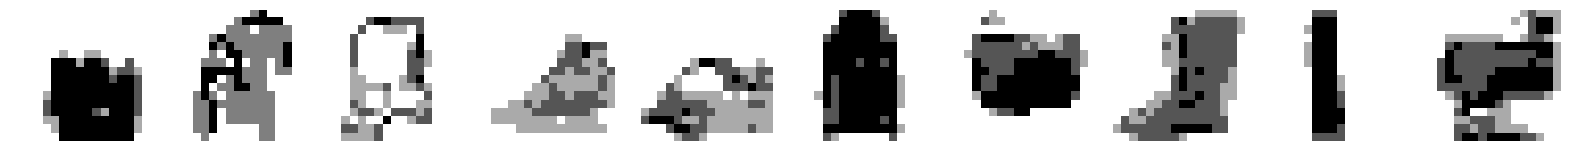

469/469 [==============================] - 31s 66ms/step - loss: 0.3224
Epoch 141/150
469/469 [==============================] - ETA: 0s - loss: 0.3222
Saved to ./output/generated_img_140.png


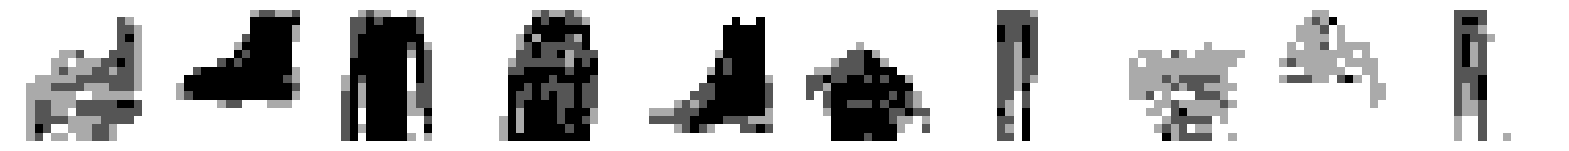

469/469 [==============================] - 32s 68ms/step - loss: 0.3222
Epoch 142/150
467/469 [============================>.] - ETA: 0s - loss: 0.3224
Saved to ./output/generated_img_141.png


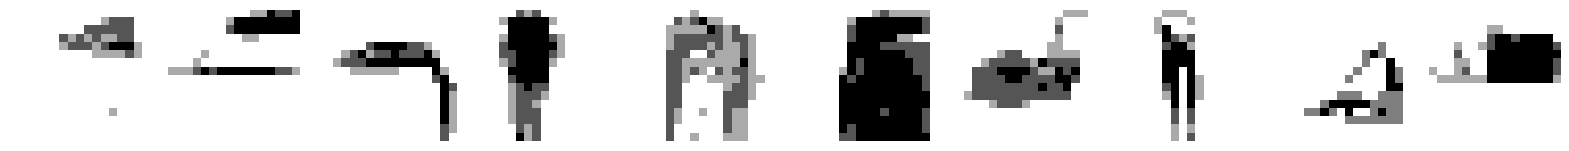

469/469 [==============================] - 30s 64ms/step - loss: 0.3224
Epoch 143/150
469/469 [==============================] - ETA: 0s - loss: 0.3223
Saved to ./output/generated_img_142.png


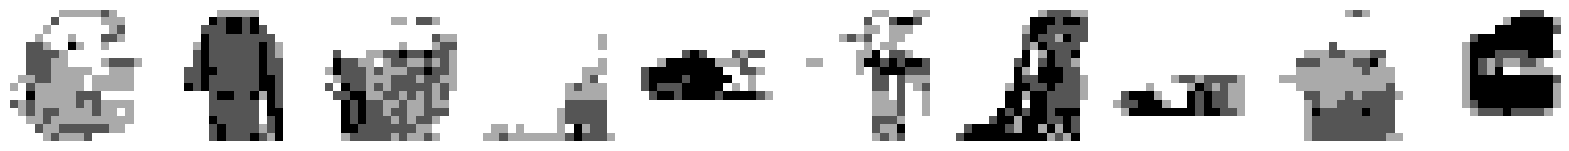

469/469 [==============================] - 31s 67ms/step - loss: 0.3223
Epoch 144/150
469/469 [==============================] - ETA: 0s - loss: 0.3222
Saved to ./output/generated_img_143.png


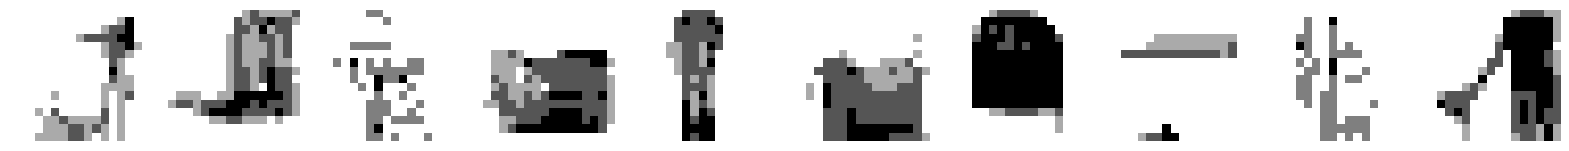

469/469 [==============================] - 31s 65ms/step - loss: 0.3222
Epoch 145/150
467/469 [============================>.] - ETA: 0s - loss: 0.3222
Saved to ./output/generated_img_144.png


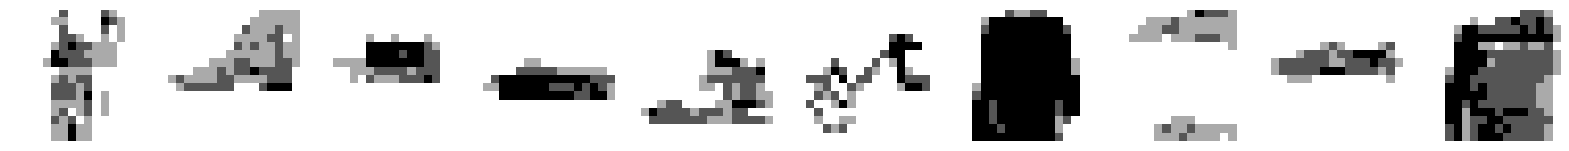

469/469 [==============================] - 30s 64ms/step - loss: 0.3221
Epoch 146/150
467/469 [============================>.] - ETA: 0s - loss: 0.3221
Saved to ./output/generated_img_145.png


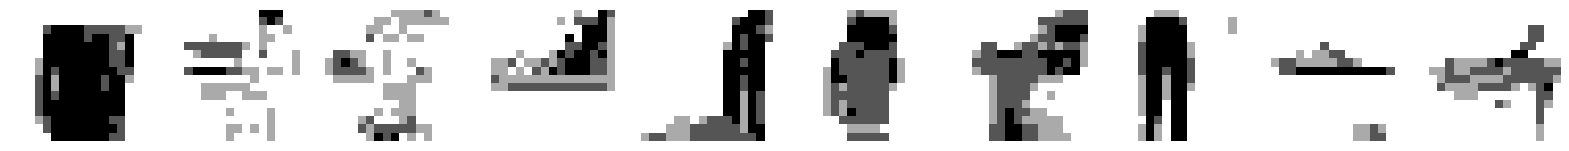

469/469 [==============================] - 32s 67ms/step - loss: 0.3221
Epoch 147/150
469/469 [==============================] - ETA: 0s - loss: 0.3219
Saved to ./output/generated_img_146.png


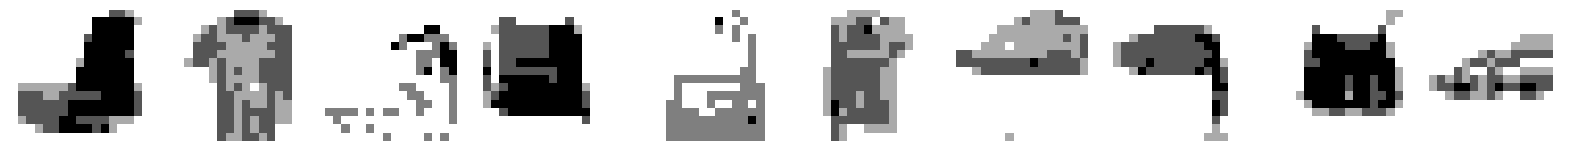

469/469 [==============================] - 30s 64ms/step - loss: 0.3219
Epoch 148/150
467/469 [============================>.] - ETA: 0s - loss: 0.3218
Saved to ./output/generated_img_147.png


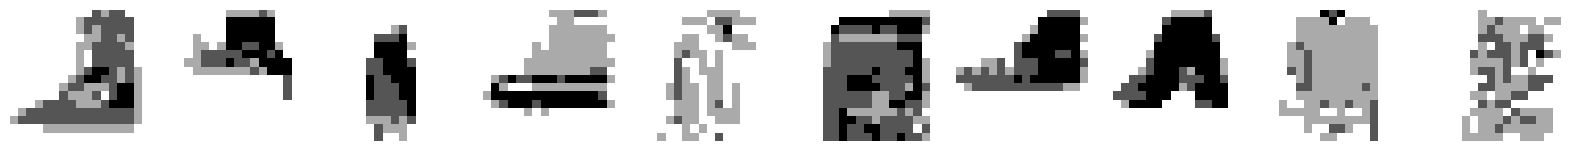

469/469 [==============================] - 32s 67ms/step - loss: 0.3218
Epoch 149/150
469/469 [==============================] - ETA: 0s - loss: 0.3218
Saved to ./output/generated_img_148.png


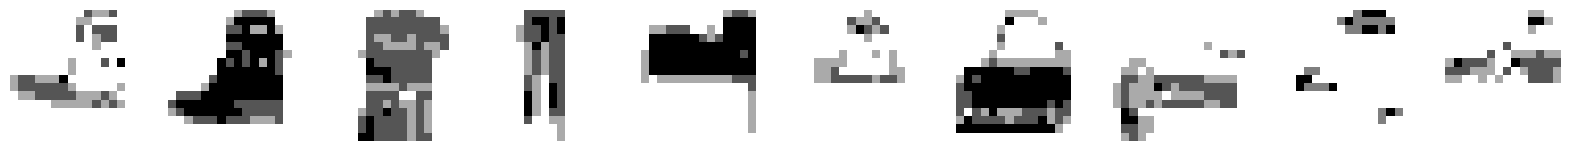

469/469 [==============================] - 34s 72ms/step - loss: 0.3218
Epoch 150/150
469/469 [==============================] - ETA: 0s - loss: 0.3218
Saved to ./output/generated_img_149.png


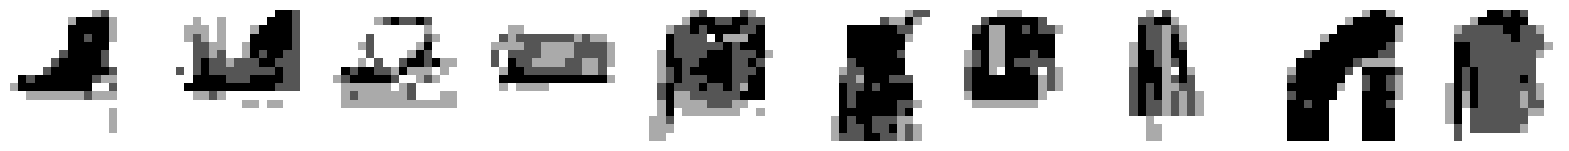

469/469 [==============================] - 31s 66ms/step - loss: 0.3218


In [25]:
pixelcnn.fit(
    input_data,
    output_data,
    batch_size=128,
    epochs=150,
    callbacks=[tensorboard_callback, img_generator_callback],
)

In [ ]:
generated_images = img_generator_callback.generate(temperature=1.0)

In [ ]:
display(generated_images)

In [30]:
import numpy as np
from tensorflow.keras import callbacks

def sample_from(probs, temperature):
    probs = probs ** (1 / temperature)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs)

def generate_images(model, num_img, temperature=1.0, save_to=None):
    generated_images = np.zeros(shape=(num_img,) + model.input_shape[1:])
    batch, rows, cols, channels = generated_images.shape

    for row in range(rows):
        for col in range(cols):
            for channel in range(channels):
                probs = model.predict(generated_images, verbose=0)[:, row, col, :]
                generated_images[:, row, col, channel] = [
                    sample_from(x, temperature) for x in probs
                ]
                generated_images[:, row, col, channel] /= 4

    if save_to:
        for i in range(num_img):
            display(generated_images[i])

    return generated_images


In [35]:
generated_images = img_generator_callback.generate(temperature=1.0)

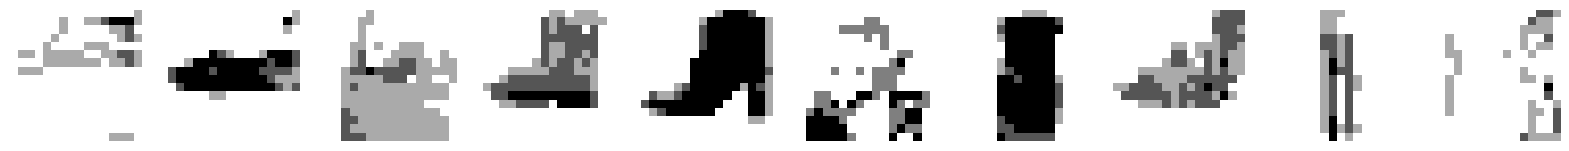

In [36]:
display(generated_images)

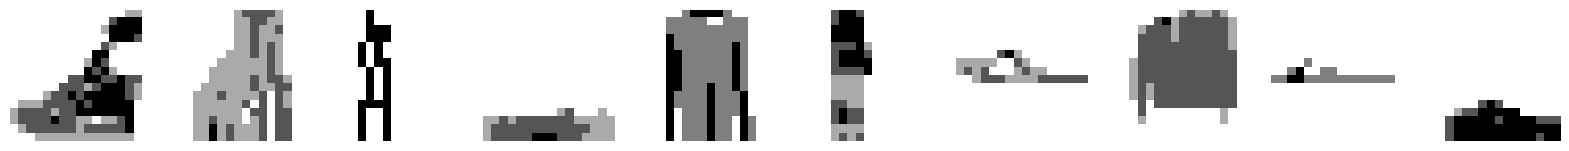

In [38]:
generated_images = img_generator_callback.generate(temperature=0.8)
display(generated_images)

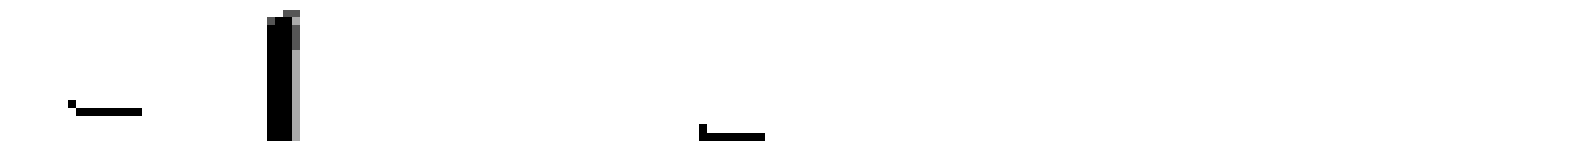

In [39]:
generated_images = img_generator_callback.generate(temperature=0.4)
display(generated_images)

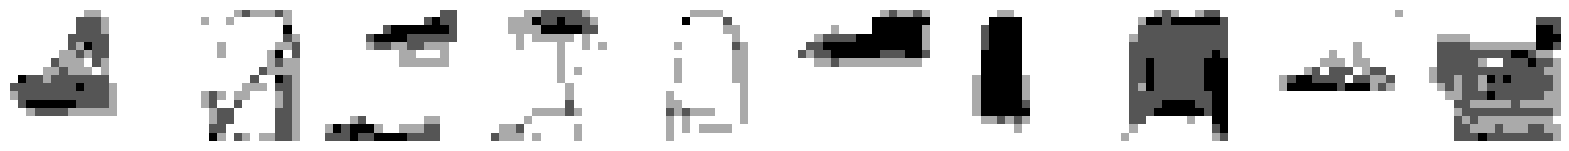

In [40]:
generated_images = img_generator_callback.generate(temperature=1)
display(generated_images)

Here more the temperature, better the outputs